This is for Chapter 12 and Week 7 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

Note that this notebook includes code for the "censored cats" discussion that was in the lecture but did not make the final, second edition section of the book. However, there's [tidyverse code](https://bookdown.org/content/4857/god-spiked-the-integers.html#bonus-survival-analysis) for this section on survival analysis. The Bayes discourse group also helped me. Thanks to Rojan for sharing his pymc code and Nathaniel for sending me pages of this section that were in a draft version of the book.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Censored cats and survival analysis

These concepts were covered in lecture 13 [here](https://youtu.be/p7g-CgGCS34?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1433). I used the R `rethinking` package to obtain the data. The question is to determine whether black cats are more discriminated against for adoption than other cats.


In [9]:
df_cats = pd.read_csv("other_data/AustinCats.csv", sep=",")
df_cats.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


<IPython.core.display.Javascript object>

In [12]:
df_cats.shape

(22356, 11)

<IPython.core.display.Javascript object>

Prepare dataframe as described in the lecture.

In [15]:
# Getting adopted is 1
df_cats["adopt"] = np.where(df_cats["out_event"] == "Adoption", 1, 0)

# It looks like he used black as lower index
df_cats["color_id"] = np.where(df_cats["color"] == "Black", 0, 1)

df_cats.head(10)

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,adopt,color_id,color_id
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,0,1,1
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,0,1,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,1,1,1
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,0,1,1
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1
5,A756485,4,08/24/2017 05:34:00 PM,Adoption,08/20/2017 03:07:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,1,1,1,1
6,A732960,4,08/19/2016 06:27:00 PM,Adoption,08/15/2016 03:08:00 PM,Stray,Domestic Shorthair Mix,Calico,2,1,1,1
7,A664571,5,10/10/2013 02:07:00 PM,Adoption,10/05/2013 01:43:00 PM,Owner Surrender,Domestic Shorthair Mix,Torbie,24,1,1,1
8,A727402,24,06/14/2016 04:18:00 PM,Adoption,05/21/2016 04:30:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby,1,1,1,1
9,A749579,2,05/18/2017 03:36:00 PM,Transfer,05/16/2017 05:19:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,3,0,1,1


<IPython.core.display.Javascript object>

In [17]:
df_cats["color_id"].value_counts()

1    19391
0     2965
Name: color_id, dtype: int64

<IPython.core.display.Javascript object>

Rojan's code

```
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
   cid=pm.Data('cid',df['black'])
    adopted=pm.intX(pm.Data('adopted',df['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
 D=pm.Potential('D',likelihood(lam=lam,obs_value=df['days_to_event'].values,censored=adopted))
  trace_1=pm.sample()

```

In [18]:
def likelihood(lam, obs_value, censored):
    return censored * tt.log(lam) - lam * obs_value

<IPython.core.display.Javascript object>

In [20]:
with pm.Model() as m_cats1:
    # priors
    a = pm.Normal("a", 0, 1, shape=2)

    mu = pm.math.exp(a[df_cats["color_id"]])
    lam = pm.Deterministic("lam", 1 / mu)

    D = pm.Potential(
        "D",
        likelihood(
            lam=lam,
            obs_value=df_cats["days_to_event"].values,
            censored=df_cats["adopt"],
        ),
    )

    trace_1 = pm.sample(1000, tune=1000, return_inferencedata=True)

NameError: name 'tt' is not defined

<IPython.core.display.Javascript object>

# Question 1 (12H7)

In the Trolley data—`data(Trolley)`—we saw how education level (modeled as an ordered category) is associated with responses. Is this association causal? One plausible confound is that education is also associated with age, through a causal process: People are older when they finish school than when they begin it.

Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statistical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

## Data exploration and setup

In [6]:
df_trolley = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Trolley.csv",
    delimiter=";",
)
df_trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


<IPython.core.display.Javascript object>

In [7]:
print("shape of df: ", df_trolley.shape)

shape of df:  (9930, 12)


<IPython.core.display.Javascript object>

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


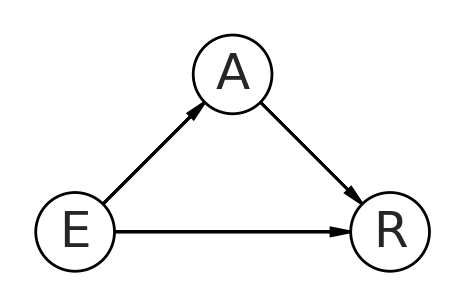

<IPython.core.display.Javascript object>

In [8]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


## Original model

Before working on the problem, I'd like to make sure I understood the book chapter code well and reproduce the results, before adding the education variable.

### Model equation

$$R_i \text{ ~ } \text{Ordered-logit}(\phi_i,\kappa) \tag{probability of data}$$ 

$$\phi_i = 0 \tag{linear model}$$ 

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5) \tag{common prior for each intercept}$$

However, he states that the model can be re-written more literally where we instead use a vector of probabilities **p**.

$$R_i \text{ ~ } \text{Categorical}(\boldsymbol{p}) \tag{probability of data}$$

$$p_1 = q_1 \tag{probabilities of each value k}$$ 

$$p_k = q_k - q_{k-1} \text{  for $K > k > 1$} $$

$$p_k = 1 - q_{k-1} $$

$$\text{logit}(q_k) = \kappa_k - \phi_i  \tag{cumulative logit link}$$ 

$$\phi_i = \text{terms of linear model}  \tag{linear model}$$

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5)  \tag{common prior for each intercept}$$



Note that McElreath uses Greek letter \(\kappa\) (kappa) to refer to the intercepts but he switches to using \(\alpha\) later.


In [9]:
df_trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


<IPython.core.display.Javascript object>

### Intercept only model

The intercepts represent the cutpoints in the cumulative probability graph. We should expect the posterior distribution cutpoints to monotonically increase after we run this code.

Here is the setup in pymc as taken from the repo. Per McElreath's text: "In code form for either quap and ulam, the link function will be embedded in the likelihood function already." McElreath cautions that this can take a while but it only took ~30 seconds for me.

In [10]:
with pm.Model() as m12_4:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,  # array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=df_trolley["response"] - 1)

    # Get posterior
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

Let's get our trace object back as a dataframe and inspect.

In [12]:
trace_12_4_df = trace_12_4.to_dataframe()
trace_12_4_df

,chain,draw,"(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)","(posterior, cutpoints[3], 3)","(posterior, cutpoints[4], 4)","(posterior, cutpoints[5], 5)","(log_likelihood, R[0], 0)","(log_likelihood, R[1000], 1000)",...,"(sample_stats, perf_counter_start)","(sample_stats, mean_tree_accept)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, lp)","(sample_stats, step_size_bar)","(sample_stats, energy)","(sample_stats, diverging)","(sample_stats, step_size)","(sample_stats, tree_size)"
0,0,0,-1.944997,-1.271992,-0.723195,0.262819,0.889961,1.767569,-1.432802,-1.432802,...,13.263790,0.907547,0.232490,3,-18934.589937,0.608521,18938.422333,False,0.626648,7.0
1,0,1,-1.891395,-1.259263,-0.718099,0.223384,0.871716,1.732266,-1.479273,-1.479273,...,13.266112,0.812892,0.511403,3,-18935.223347,0.608521,18936.294713,False,0.626648,7.0
2,0,2,-1.902102,-1.269827,-0.699676,0.270881,0.904259,1.786165,-1.446362,-1.446362,...,13.268653,0.979887,-0.355113,3,-18934.804766,0.608521,18936.865974,False,0.626648,7.0
3,0,3,-1.913761,-1.259292,-0.734792,0.225806,0.879706,1.766346,-1.460722,-1.460722,...,13.271228,0.985648,-0.222621,3,-18934.686169,0.608521,18937.144085,False,0.626648,7.0
4,0,4,-1.886907,-1.256226,-0.724622,0.226160,0.851608,1.738584,-1.470006,-1.470006,...,13.274018,0.390269,5.562225,3,-18935.640649,0.608521,18940.391810,False,0.626648,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3,995,-1.900627,-1.243956,-0.678162,0.277044,0.910309,1.791648,-1.460373,-1.460373,...,18.166593,0.809510,0.623582,3,-18935.174422,0.674049,18939.028060,False,0.644904,7.0
3996,3,996,-1.912429,-1.263198,-0.723993,0.255216,0.907415,1.784581,-1.439925,-1.439925,...,18.168878,0.965441,-0.651841,3,-18933.662770,0.674049,18936.193592,False,0.644904,7.0
3997,3,997,-1.909409,-1.258437,-0.737196,0.255319,0.881452,1.763388,-1.427668,-1.427668,...,18.171324,0.713772,0.508577,2,-18935.718917,0.674049,18936.618605,False,0.644904,3.0
3998,3,998,-1.949809,-1.282035,-0.719329,0.225058,0.869017,1.709517,-1.476275,-1.476275,...,18.172492,0.798884,0.468529,3,-18936.841138,0.674049,18939.539187,False,0.644904,7.0


<IPython.core.display.Javascript object>

I did not inspect too closely but nothing seems out of the ordinary at first glance. Now let's take a look at the summary to see what the cutpoint values look like.

In [13]:
az.summary(trace_12_4)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.917,0.030,-1.961,-1.866,0.0,0.0,4392.0,4392.0,4396.0,2633.0,1.0
cutpoints[1],-1.266,0.024,-1.302,-1.226,0.0,0.0,4999.0,4999.0,4997.0,3517.0,1.0
cutpoints[2],-0.718,0.022,-0.753,-0.685,0.0,0.0,5227.0,5221.0,5203.0,3520.0,1.0
cutpoints[3],0.248,0.020,0.219,0.283,0.0,0.0,4775.0,4735.0,4795.0,3613.0,1.0
cutpoints[4],0.890,0.022,0.856,0.926,0.0,0.0,4918.0,4918.0,4883.0,3542.0,1.0
cutpoints[5],1.770,0.029,1.727,1.817,0.0,0.0,5106.0,5094.0,5125.0,3798.0,1.0


<IPython.core.display.Javascript object>

The cutpoints are increasing monotonically as expected. As a reminder, these values are logit values, meaning we have to apply logistic to get back interpretable probabilities. The seventh and final cutpoint is always omitted since that, by definition, is 1 (after applying logistic). Trying to get the logit value is also not practical since logit(1) is infinity as shown below.

In [26]:
from scipy.special import logit

print(logit(0.90))
print(logit(0.9999))
print(logit(1))

2.1972245773362196
9.21024036697596
inf


<IPython.core.display.Javascript object>

Now let's get the cumulative probabilities back using the logistic function.

In [27]:
cutpoints_mean = trace_12_4_df[
    [("posterior", "cutpoints" + str([i]), i) for i in range(6)]
].mean()

# Get cumulative probabilities back
logistic(cutpoints_mean.round(3))

(posterior, cutpoints[0], 0)    0.128196
(posterior, cutpoints[1], 1)    0.219943
(posterior, cutpoints[2], 2)    0.327834
(posterior, cutpoints[3], 3)    0.561684
(posterior, cutpoints[4], 4)    0.708890
(posterior, cutpoints[5], 5)    0.854458
dtype: float64

<IPython.core.display.Javascript object>

Now let's move on to the model where we add predictor variables.

### Model with predictor variables

We'll define a linear model $\phi_i = \beta x_i$, then each cumulative logit becomes:

$$\text{log} \frac{\text{Pr}(y_i \leq k)}{1-\text{Pr}(y_i \leq k)} = \alpha_k - \phi_i $$

$$\phi_i = \beta x_i$$


Note here \(\alpha\) is referring to the intercept term when he had used \(\kappa\) before. The predictor variables are `action`, `intention`, and `contact` coded as indicator variables. Let's remind ourselves how the dataframe looks.

In [28]:
df_trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


<IPython.core.display.Javascript object>

This cell took a little bit longer to run. Let's use most of the repo code for creating and running this model.

I am not 100% sure but I believe the adjustment made here `observed=df_trolley["response"]-1` is to account for Python 0 indexing.

In [15]:
with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", df_trolley["action"])
    I = pm.Data("I", df_trolley["intention"])
    C = pm.Data("C", df_trolley["contact"])
    
    # This defines the interaction of intention between action and contact
    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"]-1     # 
    )

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


<IPython.core.display.Javascript object>

#### Prior predictions of cutpoints

In [16]:
with m12_5:
    prior_pc = pm.sample_prior_predictive(var_names=["cutpoints"])

prior_pc

{'cutpoints': array([[ 0.4829748 , -0.66830496, -1.82323996, -1.3544437 ,  0.1927315 ,
          2.03145122],
        [-2.45846252,  0.86345799, -1.03185964, -2.59275704,  0.07559416,
         -1.48363566],
        [-1.70232248,  2.67121702, -1.21962682,  0.91437455, -3.08300344,
          0.6479137 ],
        ...,
        [-2.46078188,  0.59585646,  1.20482999, -1.60165107, -1.44837751,
         -1.30090619],
        [-2.17248438, -0.43314908, -1.72181921,  1.4220979 , -2.33111929,
         -1.07865684],
        [ 1.38872813, -0.13289177, -1.46700193,  0.07369532, -1.32569279,
         -1.264418  ]])}

<IPython.core.display.Javascript object>

In [17]:
# take the mean - I think they're going to be the same for each value which is not unexpected
prior_pc["cutpoints"].mean(axis=0)

array([ 0.03246492, -0.04754484, -0.07173158,  0.06972068, -0.00063593,
        0.09832941])

<IPython.core.display.Javascript object>

In [18]:
prior_pc["cutpoints"].std(axis=0)

array([1.50555604, 1.49764051, 1.62108526, 1.41274325, 1.48364159,
       1.50020002])

<IPython.core.display.Javascript object>

In [19]:
np.arange(6) - 2.5

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

<IPython.core.display.Javascript object>

In [20]:
# code frm repo
# idata = az.from_pymc3(trace_12_5)
# az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

<IPython.core.display.Javascript object>

In [21]:
trace_12_5_df = trace_12_5.to_dataframe()
trace_12_5_df.head()

,chain,draw,"(posterior, bA)","(posterior, bC)","(posterior, bI)","(posterior, bIA)","(posterior, bIC)","(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)",...,"(sample_stats, perf_counter_start)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, process_time_diff)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, tree_size)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, step_size)"
0,0,0,-0.505141,-0.318802,-0.327815,-0.425470,-1.150018,-2.660330,-1.955481,-1.376935,...,349.689837,0.104454,1.673077,0.104455,0.808162,False,31.0,-18476.163278,-0.333714,0.392687
1,0,1,-0.434830,-0.457989,-0.304971,-0.424522,-1.105279,-2.626617,-1.932367,-1.321066,...,349.794485,0.027108,-0.233171,0.027110,0.958164,False,7.0,-18477.479533,-0.125865,0.392687
2,0,2,-0.450218,-0.377510,-0.326047,-0.446714,-1.213259,-2.624070,-1.949052,-1.343156,...,349.821792,0.054015,0.789485,0.054006,0.750045,False,15.0,-18477.445982,-0.012350,0.392687
3,0,3,-0.388423,-0.407774,-0.188328,-0.518498,-1.236109,-2.593273,-1.898340,-1.309335,...,349.876008,0.052485,0.889859,0.052486,0.726710,False,15.0,-18481.317360,0.710361,0.392687
4,0,4,-0.423833,-0.255446,-0.319680,-0.496148,-1.199826,-2.593342,-1.894928,-1.311964,...,349.928682,0.084313,3.129888,0.084182,0.838496,False,23.0,-18476.097258,-0.599234,0.392687


<IPython.core.display.Javascript object>

In [22]:
az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bIC,-1.24,0.10,-1.40,-1.09,0.0,0.0,2595.09,2595.09,2602.01,3019.21,1.0
bIA,-0.43,0.08,-0.57,-0.32,0.0,0.0,2444.25,2411.62,2443.48,2557.96,1.0
bC,-0.34,0.07,-0.46,-0.24,0.0,0.0,2462.52,2450.59,2459.41,2884.44,1.0
bI,-0.29,0.06,-0.39,-0.21,0.0,0.0,2204.02,2192.90,2200.24,2552.76,1.0
bA,-0.47,0.05,-0.56,-0.39,0.0,0.0,2412.44,2412.44,2413.97,2218.64,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

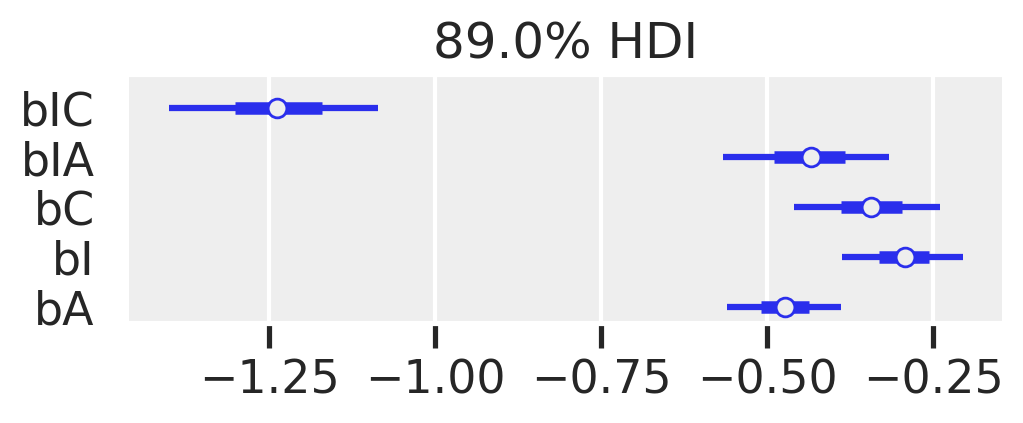

<IPython.core.display.Javascript object>

In [23]:
f, ax1 = plt.subplots(figsize=(5, 2))
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, ax=ax1
)

This is showing the combination of intention and contact is the worst, despite the fact that each by themselves isn't showing a large impact on the ratings. Let's plot the posterior predictions.

#### Plot posterior predictions

It will be easier to understand, but this is a challenge since each prediction is a vector of probabilities. We'll need to create a function that generates these predictions using the parameters of our posterior predictions. We can use the full posterior (analagous to the `sim` function) or something akin to the `link` function. McElreath's  R code 12.27 uses link. Let's take a quick look at the posterior.

#### My own code

In [24]:
trace_12_5_df.head()

,chain,draw,"(posterior, bA)","(posterior, bC)","(posterior, bI)","(posterior, bIA)","(posterior, bIC)","(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)",...,"(sample_stats, perf_counter_start)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, process_time_diff)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, tree_size)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, step_size)"
0,0,0,-0.505141,-0.318802,-0.327815,-0.425470,-1.150018,-2.660330,-1.955481,-1.376935,...,349.689837,0.104454,1.673077,0.104455,0.808162,False,31.0,-18476.163278,-0.333714,0.392687
1,0,1,-0.434830,-0.457989,-0.304971,-0.424522,-1.105279,-2.626617,-1.932367,-1.321066,...,349.794485,0.027108,-0.233171,0.027110,0.958164,False,7.0,-18477.479533,-0.125865,0.392687
2,0,2,-0.450218,-0.377510,-0.326047,-0.446714,-1.213259,-2.624070,-1.949052,-1.343156,...,349.821792,0.054015,0.789485,0.054006,0.750045,False,15.0,-18477.445982,-0.012350,0.392687
3,0,3,-0.388423,-0.407774,-0.188328,-0.518498,-1.236109,-2.593273,-1.898340,-1.309335,...,349.876008,0.052485,0.889859,0.052486,0.726710,False,15.0,-18481.317360,0.710361,0.392687
4,0,4,-0.423833,-0.255446,-0.319680,-0.496148,-1.199826,-2.593342,-1.894928,-1.311964,...,349.928682,0.084313,3.129888,0.084182,0.838496,False,23.0,-18476.097258,-0.599234,0.392687


<IPython.core.display.Javascript object>

In [25]:
def link_pp(trace, post_bA, post_bC, post_bI, post_bIA, post_bIC, in_I, in_A, in_C):
    """
    Use the model definition to generate phi.
    Input: posterior parameters and values for I, A, C
    Output: Phi (no additional sigma term?)
    """

    BI = trace[post_bI] + trace[post_bIA] * in_A + trace[post_bIC] * in_C

    phi = trace[post_bA] * in_A + trace[post_bC] * in_C + BI * in_I

    return phi

<IPython.core.display.Javascript object>

In [26]:
phi_post_0 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    0,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [27]:
phi_post_1 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    1,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [28]:
np.array([phi_post_0, phi_post_1]).reshape(-1, 2)

array([[-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       ...,
       [-0.25219887, -0.20182651],
       [-0.27349092, -0.31649199],
       [-0.24608546, -0.23015046]])

<IPython.core.display.Javascript object>

We have determined phi for two different values of intent (while holding A and C to 0). What is phi referring to? it is the outcome of the linear model for which we subtract from the intercept terms. Remember that each intercept term is a cutpoint for a particular response. And a cutpoint is cumulative probability value for that response. Let's take a look at the first cutpoint that resulted from generating the posterior distribution.

In [29]:
trace_12_5_df.head()

,chain,draw,"(posterior, bA)","(posterior, bC)","(posterior, bI)","(posterior, bIA)","(posterior, bIC)","(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)",...,"(sample_stats, perf_counter_start)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, process_time_diff)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, tree_size)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, step_size)"
0,0,0,-0.505141,-0.318802,-0.327815,-0.425470,-1.150018,-2.660330,-1.955481,-1.376935,...,349.689837,0.104454,1.673077,0.104455,0.808162,False,31.0,-18476.163278,-0.333714,0.392687
1,0,1,-0.434830,-0.457989,-0.304971,-0.424522,-1.105279,-2.626617,-1.932367,-1.321066,...,349.794485,0.027108,-0.233171,0.027110,0.958164,False,7.0,-18477.479533,-0.125865,0.392687
2,0,2,-0.450218,-0.377510,-0.326047,-0.446714,-1.213259,-2.624070,-1.949052,-1.343156,...,349.821792,0.054015,0.789485,0.054006,0.750045,False,15.0,-18477.445982,-0.012350,0.392687
3,0,3,-0.388423,-0.407774,-0.188328,-0.518498,-1.236109,-2.593273,-1.898340,-1.309335,...,349.876008,0.052485,0.889859,0.052486,0.726710,False,15.0,-18481.317360,0.710361,0.392687
4,0,4,-0.423833,-0.255446,-0.319680,-0.496148,-1.199826,-2.593342,-1.894928,-1.311964,...,349.928682,0.084313,3.129888,0.084182,0.838496,False,23.0,-18476.097258,-0.599234,0.392687


<IPython.core.display.Javascript object>

In [60]:
trace_12_5_df.shape

(4000, 19886)

<IPython.core.display.Javascript object>

In [62]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2535]', 2535)
('posterior', 'phi[2536]', 2536)
('posterior', 'phi[2537]', 2537)
('posterior', 'phi[2538]', 2538)
('posterior', 'phi[2539]', 2539)
('posterior', 'phi[253]', 253)
('posterior', 'phi[2540]', 2540)
('posterior', 'phi[2541]', 2541)
('posterior', 'phi[2542]', 2542)
('posterior', 'phi[2543]', 2543)
('posterior', 'phi[2544]', 2544)
('posterior', 'phi[2545]', 2545)
('posterior', 'phi[2546]', 2546)
('posterior', 'phi[2547]', 2547)
('posterior', 'phi[2548]', 2548)
('posterior', 'phi[2549]', 2549)
('posterior', 'phi[254]', 254)
('posterior', 'phi[2550]', 2550)
('posterior', 'phi[2551]', 2551)
('posterior', 'phi[2552]', 2552)
('posterior', 'phi[2553]', 2553)
('posterior', 'phi[2554]', 2554)
('posterior', 'phi[2555]', 2555)
('posterior', 'phi[2556]', 2556)
('posterior', 'phi[2557]', 2557)
('posterior', 'phi[2558]', 2558)
('posterior', 'phi[2559]', 2559)
('posterior', 'phi[255]', 255)
('posterior', 'phi[2560]', 2560)
('posterior', 'phi[2561]', 2561)
('posterior', 'p

('posterior', 'phi[3885]', 3885)
('posterior', 'phi[3886]', 3886)
('posterior', 'phi[3887]', 3887)
('posterior', 'phi[3888]', 3888)
('posterior', 'phi[3889]', 3889)
('posterior', 'phi[388]', 388)
('posterior', 'phi[3890]', 3890)
('posterior', 'phi[3891]', 3891)
('posterior', 'phi[3892]', 3892)
('posterior', 'phi[3893]', 3893)
('posterior', 'phi[3894]', 3894)
('posterior', 'phi[3895]', 3895)
('posterior', 'phi[3896]', 3896)
('posterior', 'phi[3897]', 3897)
('posterior', 'phi[3898]', 3898)
('posterior', 'phi[3899]', 3899)
('posterior', 'phi[389]', 389)
('posterior', 'phi[38]', 38)
('posterior', 'phi[3900]', 3900)
('posterior', 'phi[3901]', 3901)
('posterior', 'phi[3902]', 3902)
('posterior', 'phi[3903]', 3903)
('posterior', 'phi[3904]', 3904)
('posterior', 'phi[3905]', 3905)
('posterior', 'phi[3906]', 3906)
('posterior', 'phi[3907]', 3907)
('posterior', 'phi[3908]', 3908)
('posterior', 'phi[3909]', 3909)
('posterior', 'phi[390]', 390)
('posterior', 'phi[3910]', 3910)
('posterior', 'phi[3

('posterior', 'phi[531]', 531)
('posterior', 'phi[5320]', 5320)
('posterior', 'phi[5321]', 5321)
('posterior', 'phi[5322]', 5322)
('posterior', 'phi[5323]', 5323)
('posterior', 'phi[5324]', 5324)
('posterior', 'phi[5325]', 5325)
('posterior', 'phi[5326]', 5326)
('posterior', 'phi[5327]', 5327)
('posterior', 'phi[5328]', 5328)
('posterior', 'phi[5329]', 5329)
('posterior', 'phi[532]', 532)
('posterior', 'phi[5330]', 5330)
('posterior', 'phi[5331]', 5331)
('posterior', 'phi[5332]', 5332)
('posterior', 'phi[5333]', 5333)
('posterior', 'phi[5334]', 5334)
('posterior', 'phi[5335]', 5335)
('posterior', 'phi[5336]', 5336)
('posterior', 'phi[5337]', 5337)
('posterior', 'phi[5338]', 5338)
('posterior', 'phi[5339]', 5339)
('posterior', 'phi[533]', 533)
('posterior', 'phi[5340]', 5340)
('posterior', 'phi[5341]', 5341)
('posterior', 'phi[5342]', 5342)
('posterior', 'phi[5343]', 5343)
('posterior', 'phi[5344]', 5344)
('posterior', 'phi[5345]', 5345)
('posterior', 'phi[5346]', 5346)
('posterior', 'p

('posterior', 'phi[6584]', 6584)
('posterior', 'phi[6585]', 6585)
('posterior', 'phi[6586]', 6586)
('posterior', 'phi[6587]', 6587)
('posterior', 'phi[6588]', 6588)
('posterior', 'phi[6589]', 6589)
('posterior', 'phi[658]', 658)
('posterior', 'phi[6590]', 6590)
('posterior', 'phi[6591]', 6591)
('posterior', 'phi[6592]', 6592)
('posterior', 'phi[6593]', 6593)
('posterior', 'phi[6594]', 6594)
('posterior', 'phi[6595]', 6595)
('posterior', 'phi[6596]', 6596)
('posterior', 'phi[6597]', 6597)
('posterior', 'phi[6598]', 6598)
('posterior', 'phi[6599]', 6599)
('posterior', 'phi[659]', 659)
('posterior', 'phi[65]', 65)
('posterior', 'phi[6600]', 6600)
('posterior', 'phi[6601]', 6601)
('posterior', 'phi[6602]', 6602)
('posterior', 'phi[6603]', 6603)
('posterior', 'phi[6604]', 6604)
('posterior', 'phi[6605]', 6605)
('posterior', 'phi[6606]', 6606)
('posterior', 'phi[6607]', 6607)
('posterior', 'phi[6608]', 6608)
('posterior', 'phi[6609]', 6609)
('posterior', 'phi[660]', 660)
('posterior', 'phi[6

('posterior', 'phi[8384]', 8384)
('posterior', 'phi[8385]', 8385)
('posterior', 'phi[8386]', 8386)
('posterior', 'phi[8387]', 8387)
('posterior', 'phi[8388]', 8388)
('posterior', 'phi[8389]', 8389)
('posterior', 'phi[838]', 838)
('posterior', 'phi[8390]', 8390)
('posterior', 'phi[8391]', 8391)
('posterior', 'phi[8392]', 8392)
('posterior', 'phi[8393]', 8393)
('posterior', 'phi[8394]', 8394)
('posterior', 'phi[8395]', 8395)
('posterior', 'phi[8396]', 8396)
('posterior', 'phi[8397]', 8397)
('posterior', 'phi[8398]', 8398)
('posterior', 'phi[8399]', 8399)
('posterior', 'phi[839]', 839)
('posterior', 'phi[83]', 83)
('posterior', 'phi[8400]', 8400)
('posterior', 'phi[8401]', 8401)
('posterior', 'phi[8402]', 8402)
('posterior', 'phi[8403]', 8403)
('posterior', 'phi[8404]', 8404)
('posterior', 'phi[8405]', 8405)
('posterior', 'phi[8406]', 8406)
('posterior', 'phi[8407]', 8407)
('posterior', 'phi[8408]', 8408)
('posterior', 'phi[8409]', 8409)
('posterior', 'phi[840]', 840)
('posterior', 'phi[8

('posterior', 'phi[9733]', 9733)
('posterior', 'phi[9734]', 9734)
('posterior', 'phi[9735]', 9735)
('posterior', 'phi[9736]', 9736)
('posterior', 'phi[9737]', 9737)
('posterior', 'phi[9738]', 9738)
('posterior', 'phi[9739]', 9739)
('posterior', 'phi[973]', 973)
('posterior', 'phi[9740]', 9740)
('posterior', 'phi[9741]', 9741)
('posterior', 'phi[9742]', 9742)
('posterior', 'phi[9743]', 9743)
('posterior', 'phi[9744]', 9744)
('posterior', 'phi[9745]', 9745)
('posterior', 'phi[9746]', 9746)
('posterior', 'phi[9747]', 9747)
('posterior', 'phi[9748]', 9748)
('posterior', 'phi[9749]', 9749)
('posterior', 'phi[974]', 974)
('posterior', 'phi[9750]', 9750)
('posterior', 'phi[9751]', 9751)
('posterior', 'phi[9752]', 9752)
('posterior', 'phi[9753]', 9753)
('posterior', 'phi[9754]', 9754)
('posterior', 'phi[9755]', 9755)
('posterior', 'phi[9756]', 9756)
('posterior', 'phi[9757]', 9757)
('posterior', 'phi[9758]', 9758)
('posterior', 'phi[9759]', 9759)
('posterior', 'phi[975]', 975)
('posterior', 'p

('log_likelihood', 'resp_obs[0,2145]', 0, 2145)
('log_likelihood', 'resp_obs[0,2146]', 0, 2146)
('log_likelihood', 'resp_obs[0,2147]', 0, 2147)
('log_likelihood', 'resp_obs[0,2148]', 0, 2148)
('log_likelihood', 'resp_obs[0,2149]', 0, 2149)
('log_likelihood', 'resp_obs[0,214]', 0, 214)
('log_likelihood', 'resp_obs[0,2150]', 0, 2150)
('log_likelihood', 'resp_obs[0,2151]', 0, 2151)
('log_likelihood', 'resp_obs[0,2152]', 0, 2152)
('log_likelihood', 'resp_obs[0,2153]', 0, 2153)
('log_likelihood', 'resp_obs[0,2154]', 0, 2154)
('log_likelihood', 'resp_obs[0,2155]', 0, 2155)
('log_likelihood', 'resp_obs[0,2156]', 0, 2156)
('log_likelihood', 'resp_obs[0,2157]', 0, 2157)
('log_likelihood', 'resp_obs[0,2158]', 0, 2158)
('log_likelihood', 'resp_obs[0,2159]', 0, 2159)
('log_likelihood', 'resp_obs[0,215]', 0, 215)
('log_likelihood', 'resp_obs[0,2160]', 0, 2160)
('log_likelihood', 'resp_obs[0,2161]', 0, 2161)
('log_likelihood', 'resp_obs[0,2162]', 0, 2162)
('log_likelihood', 'resp_obs[0,2163]', 0, 21

('log_likelihood', 'resp_obs[0,3871]', 0, 3871)
('log_likelihood', 'resp_obs[0,3872]', 0, 3872)
('log_likelihood', 'resp_obs[0,3873]', 0, 3873)
('log_likelihood', 'resp_obs[0,3874]', 0, 3874)
('log_likelihood', 'resp_obs[0,3875]', 0, 3875)
('log_likelihood', 'resp_obs[0,3876]', 0, 3876)
('log_likelihood', 'resp_obs[0,3877]', 0, 3877)
('log_likelihood', 'resp_obs[0,3878]', 0, 3878)
('log_likelihood', 'resp_obs[0,3879]', 0, 3879)
('log_likelihood', 'resp_obs[0,387]', 0, 387)
('log_likelihood', 'resp_obs[0,3880]', 0, 3880)
('log_likelihood', 'resp_obs[0,3881]', 0, 3881)
('log_likelihood', 'resp_obs[0,3882]', 0, 3882)
('log_likelihood', 'resp_obs[0,3883]', 0, 3883)
('log_likelihood', 'resp_obs[0,3884]', 0, 3884)
('log_likelihood', 'resp_obs[0,3885]', 0, 3885)
('log_likelihood', 'resp_obs[0,3886]', 0, 3886)
('log_likelihood', 'resp_obs[0,3887]', 0, 3887)
('log_likelihood', 'resp_obs[0,3888]', 0, 3888)
('log_likelihood', 'resp_obs[0,3889]', 0, 3889)
('log_likelihood', 'resp_obs[0,388]', 0, 3

('log_likelihood', 'resp_obs[0,5295]', 0, 5295)
('log_likelihood', 'resp_obs[0,5296]', 0, 5296)
('log_likelihood', 'resp_obs[0,5297]', 0, 5297)
('log_likelihood', 'resp_obs[0,5298]', 0, 5298)
('log_likelihood', 'resp_obs[0,5299]', 0, 5299)
('log_likelihood', 'resp_obs[0,529]', 0, 529)
('log_likelihood', 'resp_obs[0,52]', 0, 52)
('log_likelihood', 'resp_obs[0,5300]', 0, 5300)
('log_likelihood', 'resp_obs[0,5301]', 0, 5301)
('log_likelihood', 'resp_obs[0,5302]', 0, 5302)
('log_likelihood', 'resp_obs[0,5303]', 0, 5303)
('log_likelihood', 'resp_obs[0,5304]', 0, 5304)
('log_likelihood', 'resp_obs[0,5305]', 0, 5305)
('log_likelihood', 'resp_obs[0,5306]', 0, 5306)
('log_likelihood', 'resp_obs[0,5307]', 0, 5307)
('log_likelihood', 'resp_obs[0,5308]', 0, 5308)
('log_likelihood', 'resp_obs[0,5309]', 0, 5309)
('log_likelihood', 'resp_obs[0,530]', 0, 530)
('log_likelihood', 'resp_obs[0,5310]', 0, 5310)
('log_likelihood', 'resp_obs[0,5311]', 0, 5311)
('log_likelihood', 'resp_obs[0,5312]', 0, 5312)


('log_likelihood', 'resp_obs[0,6880]', 0, 6880)
('log_likelihood', 'resp_obs[0,6881]', 0, 6881)
('log_likelihood', 'resp_obs[0,6882]', 0, 6882)
('log_likelihood', 'resp_obs[0,6883]', 0, 6883)
('log_likelihood', 'resp_obs[0,6884]', 0, 6884)
('log_likelihood', 'resp_obs[0,6885]', 0, 6885)
('log_likelihood', 'resp_obs[0,6886]', 0, 6886)
('log_likelihood', 'resp_obs[0,6887]', 0, 6887)
('log_likelihood', 'resp_obs[0,6888]', 0, 6888)
('log_likelihood', 'resp_obs[0,6889]', 0, 6889)
('log_likelihood', 'resp_obs[0,688]', 0, 688)
('log_likelihood', 'resp_obs[0,6890]', 0, 6890)
('log_likelihood', 'resp_obs[0,6891]', 0, 6891)
('log_likelihood', 'resp_obs[0,6892]', 0, 6892)
('log_likelihood', 'resp_obs[0,6893]', 0, 6893)
('log_likelihood', 'resp_obs[0,6894]', 0, 6894)
('log_likelihood', 'resp_obs[0,6895]', 0, 6895)
('log_likelihood', 'resp_obs[0,6896]', 0, 6896)
('log_likelihood', 'resp_obs[0,6897]', 0, 6897)
('log_likelihood', 'resp_obs[0,6898]', 0, 6898)
('log_likelihood', 'resp_obs[0,6899]', 0, 

('log_likelihood', 'resp_obs[0,8444]', 0, 8444)
('log_likelihood', 'resp_obs[0,8445]', 0, 8445)
('log_likelihood', 'resp_obs[0,8446]', 0, 8446)
('log_likelihood', 'resp_obs[0,8447]', 0, 8447)
('log_likelihood', 'resp_obs[0,8448]', 0, 8448)
('log_likelihood', 'resp_obs[0,8449]', 0, 8449)
('log_likelihood', 'resp_obs[0,844]', 0, 844)
('log_likelihood', 'resp_obs[0,8450]', 0, 8450)
('log_likelihood', 'resp_obs[0,8451]', 0, 8451)
('log_likelihood', 'resp_obs[0,8452]', 0, 8452)
('log_likelihood', 'resp_obs[0,8453]', 0, 8453)
('log_likelihood', 'resp_obs[0,8454]', 0, 8454)
('log_likelihood', 'resp_obs[0,8455]', 0, 8455)
('log_likelihood', 'resp_obs[0,8456]', 0, 8456)
('log_likelihood', 'resp_obs[0,8457]', 0, 8457)
('log_likelihood', 'resp_obs[0,8458]', 0, 8458)
('log_likelihood', 'resp_obs[0,8459]', 0, 8459)
('log_likelihood', 'resp_obs[0,845]', 0, 845)
('log_likelihood', 'resp_obs[0,8460]', 0, 8460)
('log_likelihood', 'resp_obs[0,8461]', 0, 8461)
('log_likelihood', 'resp_obs[0,8462]', 0, 84

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [30]:
cutpoints_col = [("posterior", "cutpoints" + "[" + str(i) + "]", i) for i in range(6)]
cutpoints_col

[('posterior', 'cutpoints[0]', 0),
 ('posterior', 'cutpoints[1]', 1),
 ('posterior', 'cutpoints[2]', 2),
 ('posterior', 'cutpoints[3]', 3),
 ('posterior', 'cutpoints[4]', 4),
 ('posterior', 'cutpoints[5]', 5)]

<IPython.core.display.Javascript object>

In [31]:
trace_12_5_df[cutpoints_col]

,"(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)","(posterior, cutpoints[3], 3)","(posterior, cutpoints[4], 4)","(posterior, cutpoints[5], 5)"
0,-2.660330,-1.955481,-1.376935,-0.331789,0.361956,1.288540
1,-2.626617,-1.932367,-1.321066,-0.299748,0.361612,1.224730
2,-2.624070,-1.949052,-1.343156,-0.323886,0.361408,1.208448
3,-2.593273,-1.898340,-1.309335,-0.278608,0.388578,1.360523
4,-2.593342,-1.894928,-1.311964,-0.283143,0.373973,1.282522
...,...,...,...,...,...,...
3995,-2.586395,-1.898478,-1.286708,-0.244881,0.421655,1.348120
3996,-2.585270,-1.890120,-1.317943,-0.292120,0.385472,1.277518
3997,-2.699694,-1.951593,-1.363629,-0.325232,0.343146,1.220257
3998,-2.607570,-1.954132,-1.364272,-0.319308,0.350943,1.280512


<IPython.core.display.Javascript object>

In [32]:
prior_pc["cutpoints"].mean(axis=0)

array([ 0.03246492, -0.04754484, -0.07173158,  0.06972068, -0.00063593,
        0.09832941])

<IPython.core.display.Javascript object>

In [33]:
phi_post_0

0      -0.0
1      -0.0
2      -0.0
3      -0.0
4      -0.0
       ... 
3995   -0.0
3996   -0.0
3997   -0.0
3998   -0.0
3999   -0.0
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [34]:
# Compare prior and posterior cutpoint means
cutpoints_pre_post = pd.DataFrame(
    {
        "prior_cutpoints": prior_pc["cutpoints"].mean(axis=0),
        "posterior_cutpoints": np.array(trace_12_5_df[cutpoints_col].mean()),
    }
)

cutpoints_pre_post

,prior_cutpoints,posterior_cutpoints
0,0.032465,-2.635954
1,-0.047545,-1.939398
2,-0.071732,-1.344338
3,0.069721,-0.309179
4,-0.000636,0.362014
5,0.098329,1.267736


<IPython.core.display.Javascript object>

The prior cutpoints do not increase monotonically but the posterior cutpoints do. We can get back the values in terms of probabilities like this:

In [35]:
logistic(cutpoints_pre_post["prior_cutpoints"])

0    0.508116
1    0.488116
2    0.482075
3    0.517423
4    0.499841
5    0.524563
Name: prior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

You can see that the prior cutpoints were really naive and just assumed that they all got around half of the responses. This is not totally logical but there's a lot of data so it doesn't matter.

In [36]:
logistic(cutpoints_pre_post["posterior_cutpoints"])

0    0.066860
1    0.125714
2    0.206798
3    0.423315
4    0.589528
5    0.780355
Name: posterior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

The posterior shows monotonically increasing cumulative probabilities as we expect. For the code related to the cutpoints, I did not yet factor in the linear model's phi term yet. We can easily do that by subtracting that out. We can also use the full posterior.

In [37]:
trace_12_5_df[cutpoints_col]

,"(posterior, cutpoints[0], 0)","(posterior, cutpoints[1], 1)","(posterior, cutpoints[2], 2)","(posterior, cutpoints[3], 3)","(posterior, cutpoints[4], 4)","(posterior, cutpoints[5], 5)"
0,-2.660330,-1.955481,-1.376935,-0.331789,0.361956,1.288540
1,-2.626617,-1.932367,-1.321066,-0.299748,0.361612,1.224730
2,-2.624070,-1.949052,-1.343156,-0.323886,0.361408,1.208448
3,-2.593273,-1.898340,-1.309335,-0.278608,0.388578,1.360523
4,-2.593342,-1.894928,-1.311964,-0.283143,0.373973,1.282522
...,...,...,...,...,...,...
3995,-2.586395,-1.898478,-1.286708,-0.244881,0.421655,1.348120
3996,-2.585270,-1.890120,-1.317943,-0.292120,0.385472,1.277518
3997,-2.699694,-1.951593,-1.363629,-0.325232,0.343146,1.220257
3998,-2.607570,-1.954132,-1.364272,-0.319308,0.350943,1.280512


<IPython.core.display.Javascript object>

In [67]:
def pordlogit_a(trace, sample_ind, phi_0, phi_1):
    """
    Input: Posterior cutpoints (intercept terms) and the phi values (posterior resulting from linear model)
    Output: Two vectors, one of I=0 and one of I=1. Each vector of discrete probabilities for each sample
    of the posterior distribution.
    """
    
    pk0 = trace.loc[sample_ind, cutpoints_col] - phi_post_0.iloc[sample_ind]
    pk1 = trace.loc[sample_ind, cutpoints_col] - phi_post_1.iloc[sample_ind]
    
    
    
    # Convert to probabilities
#     pk0 = [logistic(i) for i in pk0]
#     pk1 = [logistic(i) for i in pk1]
    
    return pk0, pk1


<IPython.core.display.Javascript object>

In [68]:
# testing
cumprob_I0_temp, cumprob_I1_temp = pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)
cumprob_I0_temp, cumprob_I1_temp

((posterior, cutpoints[0], 0)    -2.66033
 (posterior, cutpoints[1], 1)   -1.955481
 (posterior, cutpoints[2], 2)   -1.376935
 (posterior, cutpoints[3], 3)   -0.331789
 (posterior, cutpoints[4], 4)    0.361956
 (posterior, cutpoints[5], 5)     1.28854
 Name: 0, dtype: object,
 (posterior, cutpoints[0], 0)   -2.332515
 (posterior, cutpoints[1], 1)   -1.627666
 (posterior, cutpoints[2], 2)    -1.04912
 (posterior, cutpoints[3], 3)   -0.003974
 (posterior, cutpoints[4], 4)    0.689771
 (posterior, cutpoints[5], 5)    1.616355
 Name: 0, dtype: object)

<IPython.core.display.Javascript object>

In [69]:
cumprob_I0_temp

(posterior, cutpoints[0], 0)    -2.66033
(posterior, cutpoints[1], 1)   -1.955481
(posterior, cutpoints[2], 2)   -1.376935
(posterior, cutpoints[3], 3)   -0.331789
(posterior, cutpoints[4], 4)    0.361956
(posterior, cutpoints[5], 5)     1.28854
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [41]:
# This is showing how the probabilities shift
cumprob_I0, cumprob_I1 = pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)
cumprob_I0, cumprob_I1

([0.06535514737138368,
  0.12395697771404639,
  0.2015017549891868,
  0.4178054321389652,
  0.5895139025149484,
  0.7838998829286381],
 [0.08846562011541892,
  0.16415040967935604,
  0.2593942034408662,
  0.49900656606798516,
  0.6659160607935606,
  0.8342917730001637])

<IPython.core.display.Javascript object>

**Generate plots**

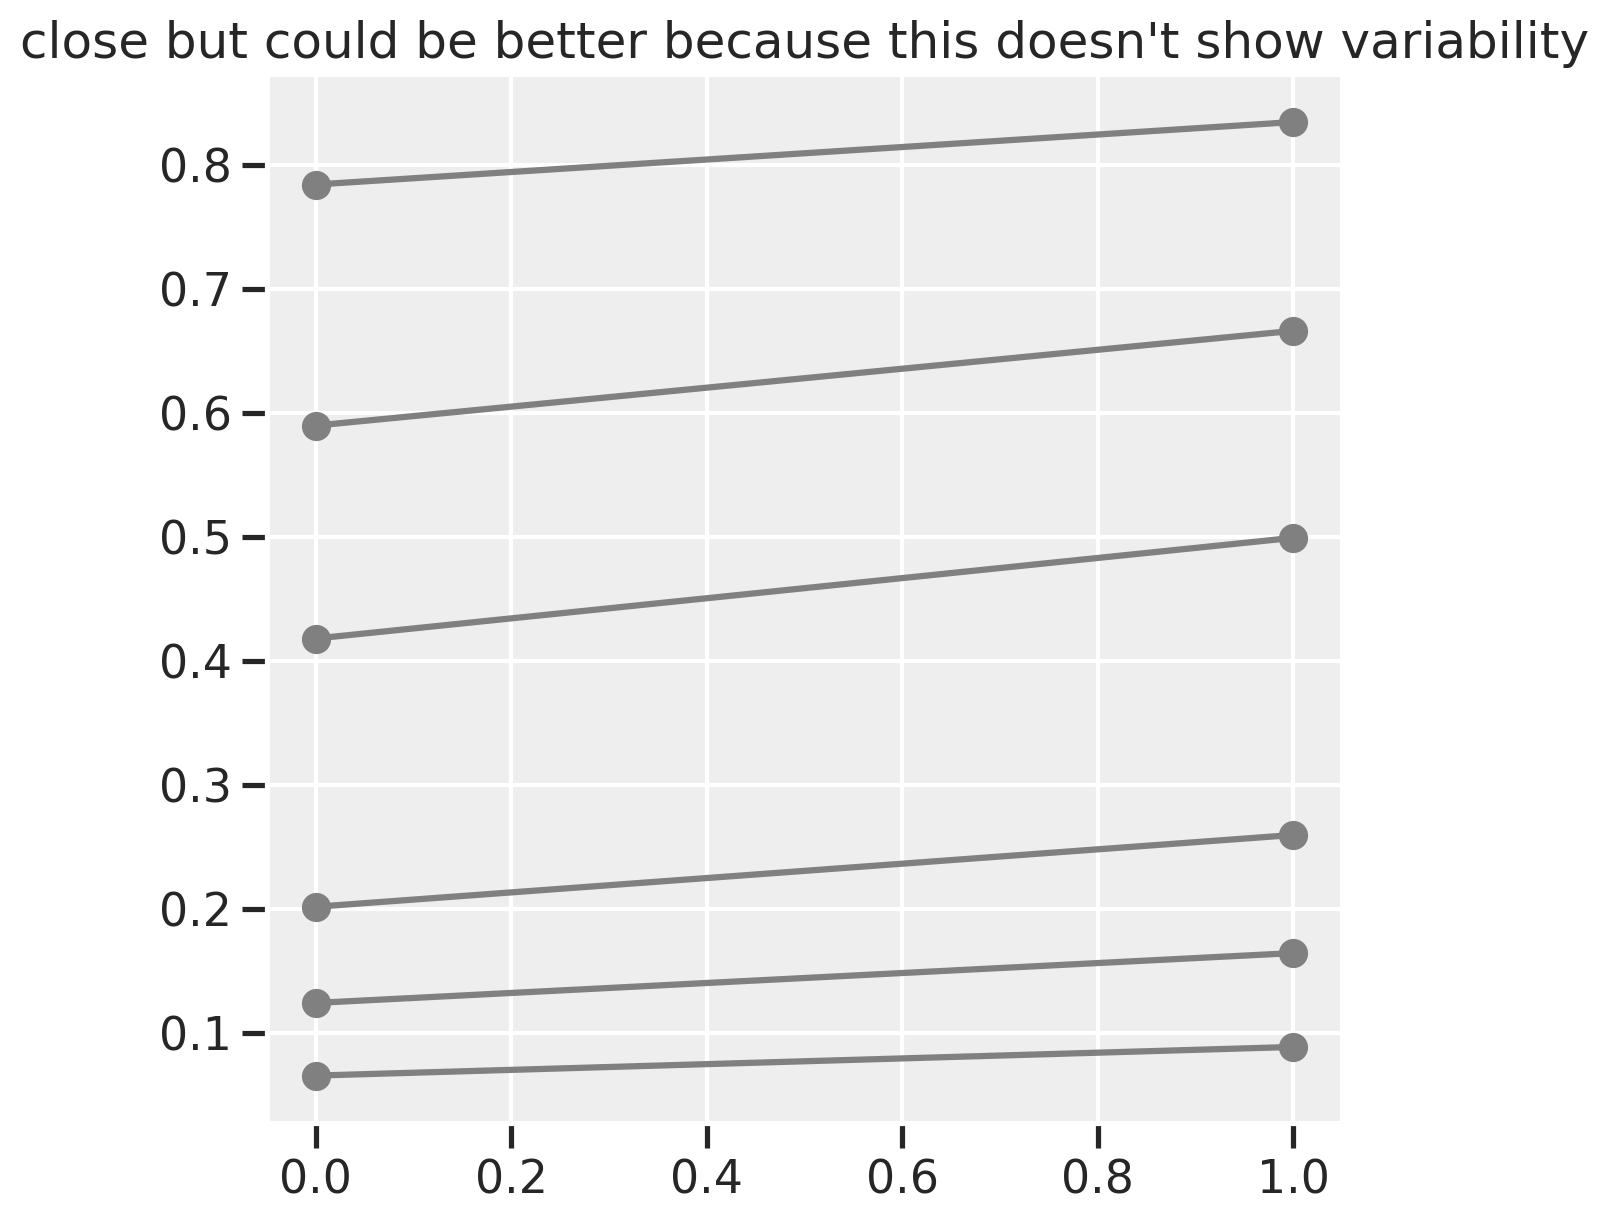

<IPython.core.display.Javascript object>

In [51]:
f, ax1 = plt.subplots(figsize=(6, 6))

for i in range(len(cumprob_I0)):
    ax1.scatter(0, cumprob_I0[i], color="gray")
    ax1.scatter(1, cumprob_I1[i], color="gray")
    ax1.plot([0, 1], [cumprob_I0[i], cumprob_I1[i]], color="gray")
    ax1.set_title("close but could be better because this doesn't show variability")

### Questions for the group/textbook

- No scaling term? link equivalent to sim and sample_posterior_predictive?
- kappa changed to alpha?

In [53]:
# posterior predictive

with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED)[
        "phi"
    ]
    

<IPython.core.display.Javascript object>

In [59]:
pp_resp["resp_obs"].shape

(4000, 9930)

<IPython.core.display.Javascript object>

In [64]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


<IPython.core.display.Javascript object>

In [66]:
resp_df = pd.DataFrame(pp_resp["resp_obs"]).T
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

0     1     2     3     4     5     6     7     \
action contact intention                                                   
0.0    0.0     0.0           2     2     4     4     6     5     6     6   
               1.0           3     3     4     5     4     0     5     5   
       1.0     0.0           3     0     3     0     3     3     4     5   
               1.0           0     0     4     3     0     3     0     4   
1.0    0.0     0.0           4     3     3     5     6     4     3     3   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
NaN    NaN     NaN           1     5     6     3     3     5     3     2   
               NaN           3     3     6     3     4     3     3     5   
               NaN           1     6     6     3     5     3     4     5   
               NaN           4     5     4     3     6     6     6     5   
               NaN           4     5     6     1     3     5     2     1   

                          8     9     ...  3990  3991  3992  3993  3994  3995  \
action contact intention              ...                                       
0.0    0.0     0.0           3     3  ...     3     3     0     4     5     6   
               1.0           5     0  ...     2     3     1     0     6     5   
       1.0     0.0           2     3  ...     0     3     5     3     5     1   
               1.0           3     2  ...     0     5     1     1     0     4   
1.0    0.0     0.0           5     5  ...     3     5     0     6     5     6   
...                        ...   ...  ...   ...   ...   ...   ...   ...   ...   
NaN    NaN     NaN           3     3  ...     5     0     3     4     6     1   
               NaN           6     3  ...     3     5     1     5     6     4   
               NaN           5     4  ...     4     3     2     3     4     4   
               NaN           0     4  ...     6     4     1     3     4     3   
               NaN           4     4  ...     6     5     3     3     3     5   

                          3996  3997  3998  3999  
action contact intention                          
0.0    0.0     0.0           3     0     4     1  
               1.0           6     3     2     3  
       1.0     0.0           0     4     5     0  
               1.0           6     0     5     4  
1.0    0.0     0.0           6     5     2     3  
...                        ...   ...   ...   ...  
NaN    NaN     NaN           3     4     4     3  
               NaN           3     3     5     5  
               NaN           1     3     4     4  
               NaN           5     0     3     5  
               NaN           5     6     0     3  

[9930 rows x 4000 columns]

<IPython.core.display.Javascript object>

(array([389., 286.,   0., 401.,   0., 988., 664.,   0., 624., 648.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

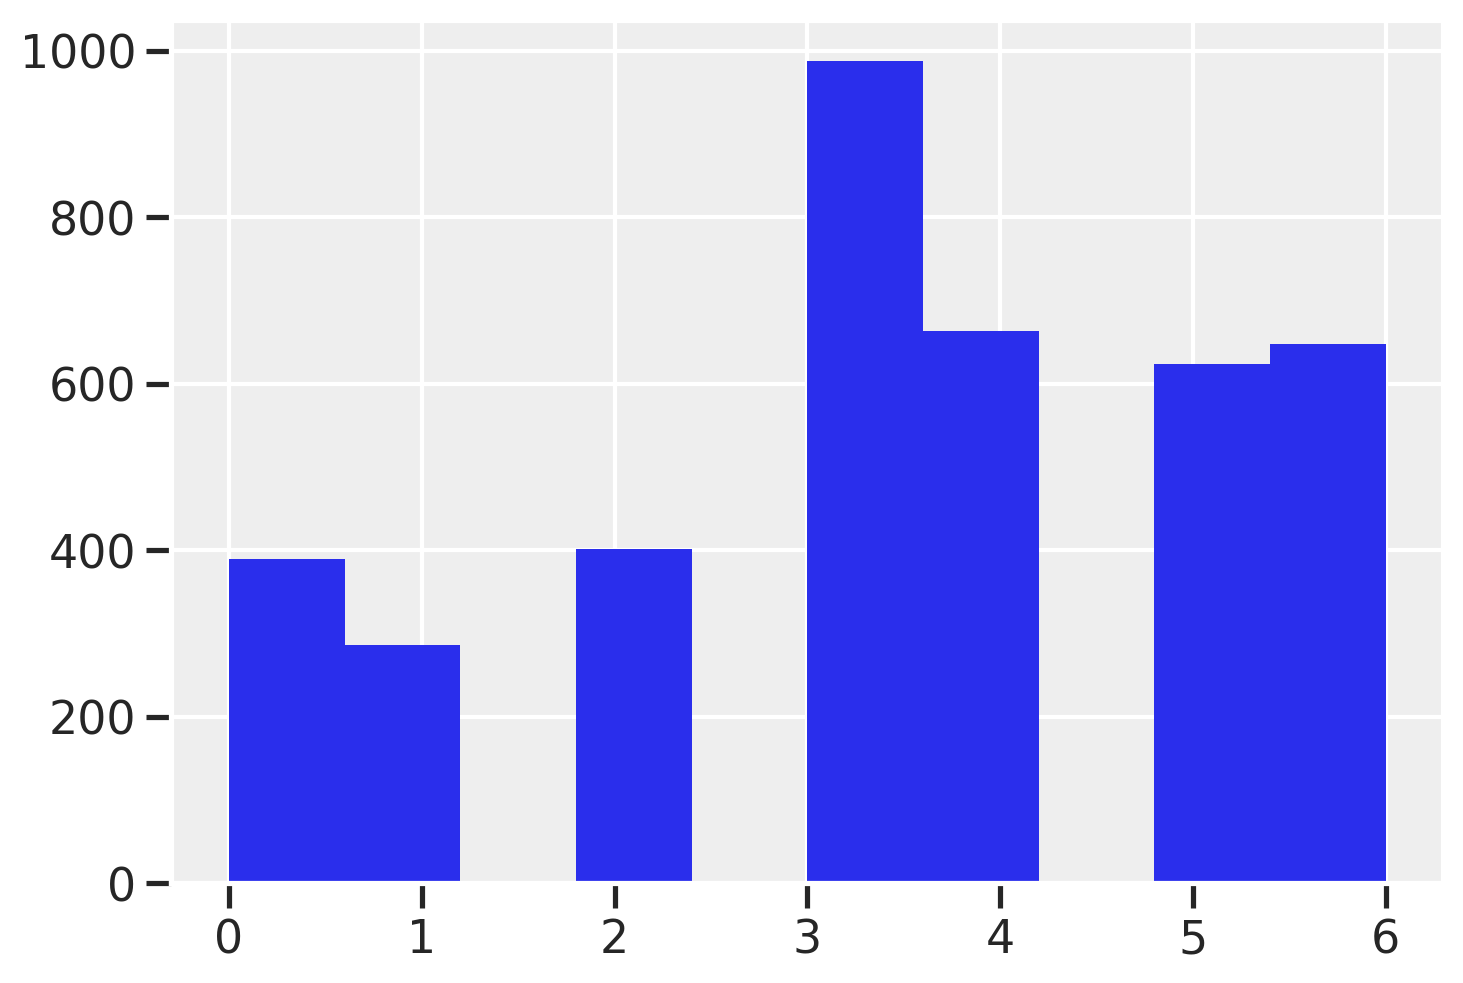

<IPython.core.display.Javascript object>

In [58]:
f, ax1 = plt.subplots()
ax1.hist(pp_resp["resp_obs"][:, 0])

In [ ]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

In [110]:
trace_12_5_df[cutpoints_col].mean()

(posterior, cutpoints[0], 0)   -2.635954
(posterior, cutpoints[1], 1)   -1.939398
(posterior, cutpoints[2], 2)   -1.344338
(posterior, cutpoints[3], 3)   -0.309179
(posterior, cutpoints[4], 4)    0.362014
(posterior, cutpoints[5], 5)    1.267736
dtype: float64

<IPython.core.display.Javascript object>

In [111]:
trace_12_5_df[cutpoints_col].std()

(posterior, cutpoints[0], 0)    0.052183
(posterior, cutpoints[1], 1)    0.047757
(posterior, cutpoints[2], 2)    0.045295
(posterior, cutpoints[3], 3)    0.043103
(posterior, cutpoints[4], 4)    0.043428
(posterior, cutpoints[5], 5)    0.046546
dtype: float64

<IPython.core.display.Javascript object>

#### Repo code

In [39]:
# Observed cum probs (from repo, great code)
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

Remember, these are cumulative probabilities. We wouldn't expect them to sum to 1 but they should monotonically increase. Below is just plotting the first row. The last value is not shown but will be 1.

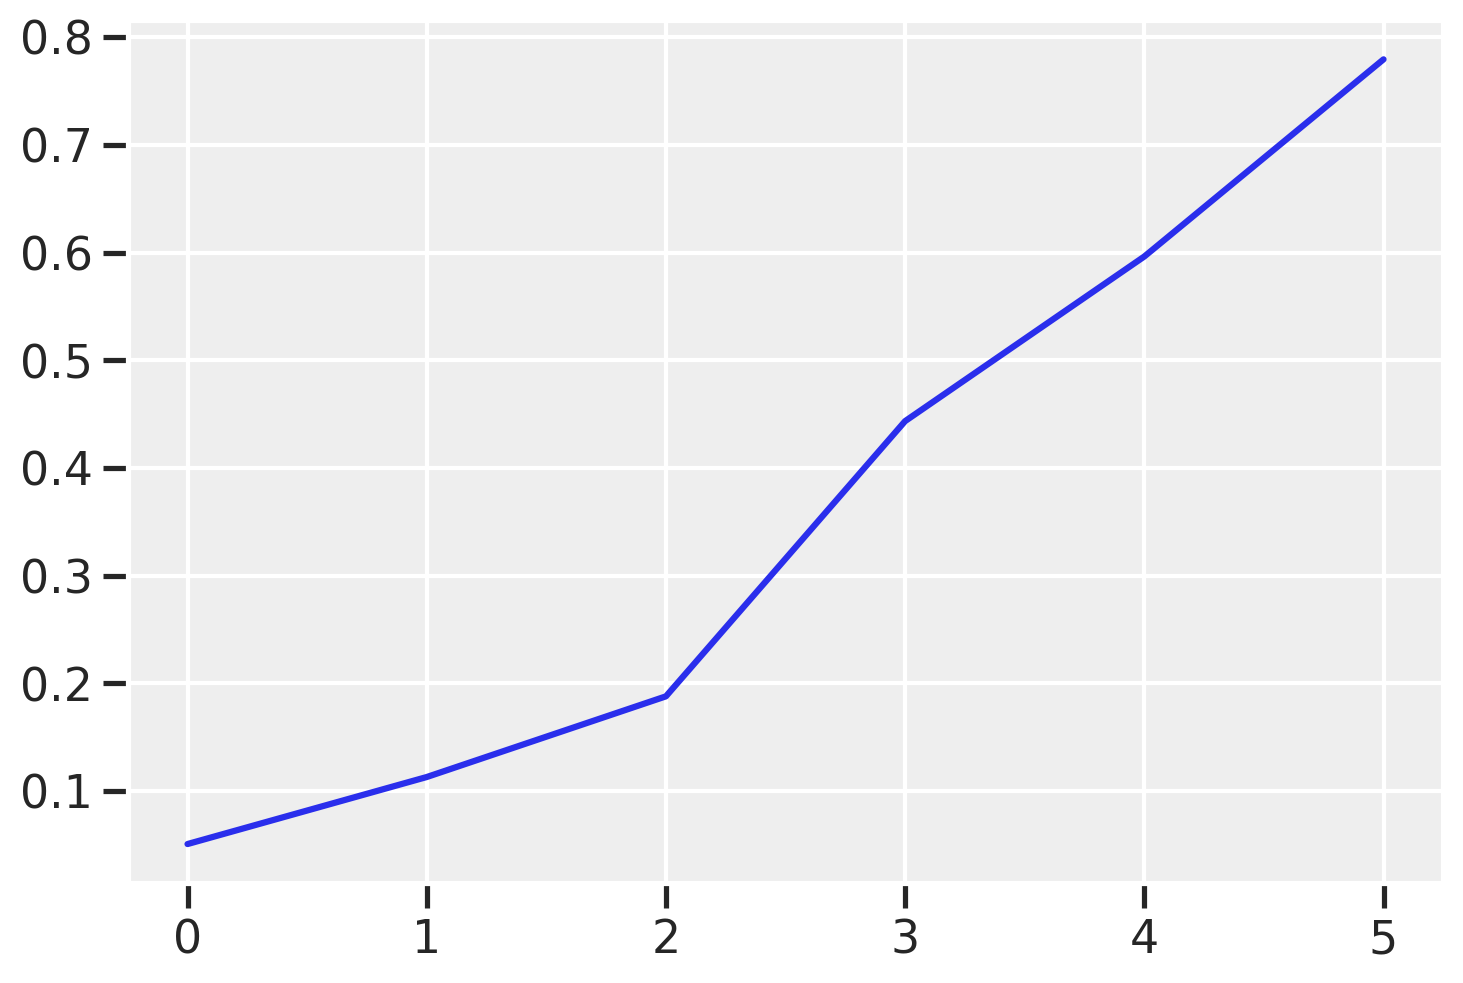

<IPython.core.display.Javascript object>

In [49]:
f, ax1 = plt.subplots()
ax1.plot(p_obs.iloc[0, :])

In [40]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


<IPython.core.display.Javascript object>

In [77]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

<IPython.core.display.Javascript object>

In [78]:
pp_phi

array([[-0.        , -0.32781511, -0.50514052, -1.25842574, -0.31880184,
        -1.79663537],
       [-0.        , -0.30497069, -0.43482973, -1.16432285, -0.45798883,
        -1.86823832],
       [-0.        , -0.32604677, -0.45021825, -1.22297916, -0.37751014,
        -1.91681543],
       ...,
       [-0.        , -0.31649199, -0.51758153, -1.23487916, -0.31441999,
        -1.86091079],
       [-0.        , -0.24608546, -0.46204498, -1.16929504, -0.3795551 ,
        -1.85152211],
       [-0.        , -0.23015046, -0.46778073, -1.14086975, -0.29713445,
        -1.79953398]])

<IPython.core.display.Javascript object>

In [79]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

<IPython.core.display.Javascript object>

In [80]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2845]', 2845)
('posterior', 'phi[2846]', 2846)
('posterior', 'phi[2847]', 2847)
('posterior', 'phi[2848]', 2848)
('posterior', 'phi[2849]', 2849)
('posterior', 'phi[284]', 284)
('posterior', 'phi[2850]', 2850)
('posterior', 'phi[2851]', 2851)
('posterior', 'phi[2852]', 2852)
('posterior', 'phi[2853]', 2853)
('posterior', 'phi[2854]', 2854)
('posterior', 'phi[2855]', 2855)
('posterior', 'phi[2856]', 2856)
('posterior', 'phi[2857]', 2857)
('posterior', 'phi[2858]', 2858)
('posterior', 'phi[2859]', 2859)
('posterior', 'phi[285]', 285)
('posterior', 'phi[2860]', 2860)
('posterior', 'phi[2861]', 2861)
('posterior', 'phi[2862]', 2862)
('posterior', 'phi[2863]', 2863)
('posterior', 'phi[2864]', 2864)
('posterior', 'phi[2865]', 2865)
('posterior', 'phi[2866]', 2866)
('posterior', 'phi[2867]', 2867)
('posterior', 'phi[2868]', 2868)
('posterior', 'phi[2869]', 2869)
('posterior', 'phi[286]', 286)
('posterior', 'phi[2870]', 2870)
('posterior', 'phi[2871]', 2871)
('posterior', 'p

('posterior', 'phi[4194]', 4194)
('posterior', 'phi[4195]', 4195)
('posterior', 'phi[4196]', 4196)
('posterior', 'phi[4197]', 4197)
('posterior', 'phi[4198]', 4198)
('posterior', 'phi[4199]', 4199)
('posterior', 'phi[419]', 419)
('posterior', 'phi[41]', 41)
('posterior', 'phi[4200]', 4200)
('posterior', 'phi[4201]', 4201)
('posterior', 'phi[4202]', 4202)
('posterior', 'phi[4203]', 4203)
('posterior', 'phi[4204]', 4204)
('posterior', 'phi[4205]', 4205)
('posterior', 'phi[4206]', 4206)
('posterior', 'phi[4207]', 4207)
('posterior', 'phi[4208]', 4208)
('posterior', 'phi[4209]', 4209)
('posterior', 'phi[420]', 420)
('posterior', 'phi[4210]', 4210)
('posterior', 'phi[4211]', 4211)
('posterior', 'phi[4212]', 4212)
('posterior', 'phi[4213]', 4213)
('posterior', 'phi[4214]', 4214)
('posterior', 'phi[4215]', 4215)
('posterior', 'phi[4216]', 4216)
('posterior', 'phi[4217]', 4217)
('posterior', 'phi[4218]', 4218)
('posterior', 'phi[4219]', 4219)
('posterior', 'phi[421]', 421)
('posterior', 'phi[4

('posterior', 'phi[5544]', 5544)
('posterior', 'phi[5545]', 5545)
('posterior', 'phi[5546]', 5546)
('posterior', 'phi[5547]', 5547)
('posterior', 'phi[5548]', 5548)
('posterior', 'phi[5549]', 5549)
('posterior', 'phi[554]', 554)
('posterior', 'phi[5550]', 5550)
('posterior', 'phi[5551]', 5551)
('posterior', 'phi[5552]', 5552)
('posterior', 'phi[5553]', 5553)
('posterior', 'phi[5554]', 5554)
('posterior', 'phi[5555]', 5555)
('posterior', 'phi[5556]', 5556)
('posterior', 'phi[5557]', 5557)
('posterior', 'phi[5558]', 5558)
('posterior', 'phi[5559]', 5559)
('posterior', 'phi[555]', 555)
('posterior', 'phi[5560]', 5560)
('posterior', 'phi[5561]', 5561)
('posterior', 'phi[5562]', 5562)
('posterior', 'phi[5563]', 5563)
('posterior', 'phi[5564]', 5564)
('posterior', 'phi[5565]', 5565)
('posterior', 'phi[5566]', 5566)
('posterior', 'phi[5567]', 5567)
('posterior', 'phi[5568]', 5568)
('posterior', 'phi[5569]', 5569)
('posterior', 'phi[556]', 556)
('posterior', 'phi[5570]', 5570)
('posterior', 'p

('posterior', 'phi[6894]', 6894)
('posterior', 'phi[6895]', 6895)
('posterior', 'phi[6896]', 6896)
('posterior', 'phi[6897]', 6897)
('posterior', 'phi[6898]', 6898)
('posterior', 'phi[6899]', 6899)
('posterior', 'phi[689]', 689)
('posterior', 'phi[68]', 68)
('posterior', 'phi[6900]', 6900)
('posterior', 'phi[6901]', 6901)
('posterior', 'phi[6902]', 6902)
('posterior', 'phi[6903]', 6903)
('posterior', 'phi[6904]', 6904)
('posterior', 'phi[6905]', 6905)
('posterior', 'phi[6906]', 6906)
('posterior', 'phi[6907]', 6907)
('posterior', 'phi[6908]', 6908)
('posterior', 'phi[6909]', 6909)
('posterior', 'phi[690]', 690)
('posterior', 'phi[6910]', 6910)
('posterior', 'phi[6911]', 6911)
('posterior', 'phi[6912]', 6912)
('posterior', 'phi[6913]', 6913)
('posterior', 'phi[6914]', 6914)
('posterior', 'phi[6915]', 6915)
('posterior', 'phi[6916]', 6916)
('posterior', 'phi[6917]', 6917)
('posterior', 'phi[6918]', 6918)
('posterior', 'phi[6919]', 6919)
('posterior', 'phi[691]', 691)
('posterior', 'phi[6

('posterior', 'phi[8296]', 8296)
('posterior', 'phi[8297]', 8297)
('posterior', 'phi[8298]', 8298)
('posterior', 'phi[8299]', 8299)
('posterior', 'phi[829]', 829)
('posterior', 'phi[82]', 82)
('posterior', 'phi[8300]', 8300)
('posterior', 'phi[8301]', 8301)
('posterior', 'phi[8302]', 8302)
('posterior', 'phi[8303]', 8303)
('posterior', 'phi[8304]', 8304)
('posterior', 'phi[8305]', 8305)
('posterior', 'phi[8306]', 8306)
('posterior', 'phi[8307]', 8307)
('posterior', 'phi[8308]', 8308)
('posterior', 'phi[8309]', 8309)
('posterior', 'phi[830]', 830)
('posterior', 'phi[8310]', 8310)
('posterior', 'phi[8311]', 8311)
('posterior', 'phi[8312]', 8312)
('posterior', 'phi[8313]', 8313)
('posterior', 'phi[8314]', 8314)
('posterior', 'phi[8315]', 8315)
('posterior', 'phi[8316]', 8316)
('posterior', 'phi[8317]', 8317)
('posterior', 'phi[8318]', 8318)
('posterior', 'phi[8319]', 8319)
('posterior', 'phi[831]', 831)
('posterior', 'phi[8320]', 8320)
('posterior', 'phi[8321]', 8321)
('posterior', 'phi[8

('posterior', 'phi[9593]', 9593)
('posterior', 'phi[9594]', 9594)
('posterior', 'phi[9595]', 9595)
('posterior', 'phi[9596]', 9596)
('posterior', 'phi[9597]', 9597)
('posterior', 'phi[9598]', 9598)
('posterior', 'phi[9599]', 9599)
('posterior', 'phi[959]', 959)
('posterior', 'phi[95]', 95)
('posterior', 'phi[9600]', 9600)
('posterior', 'phi[9601]', 9601)
('posterior', 'phi[9602]', 9602)
('posterior', 'phi[9603]', 9603)
('posterior', 'phi[9604]', 9604)
('posterior', 'phi[9605]', 9605)
('posterior', 'phi[9606]', 9606)
('posterior', 'phi[9607]', 9607)
('posterior', 'phi[9608]', 9608)
('posterior', 'phi[9609]', 9609)
('posterior', 'phi[960]', 960)
('posterior', 'phi[9610]', 9610)
('posterior', 'phi[9611]', 9611)
('posterior', 'phi[9612]', 9612)
('posterior', 'phi[9613]', 9613)
('posterior', 'phi[9614]', 9614)
('posterior', 'phi[9615]', 9615)
('posterior', 'phi[9616]', 9616)
('posterior', 'phi[9617]', 9617)
('posterior', 'phi[9618]', 9618)
('posterior', 'phi[9619]', 9619)
('posterior', 'phi

('log_likelihood', 'resp_obs[0,2389]', 0, 2389)
('log_likelihood', 'resp_obs[0,238]', 0, 238)
('log_likelihood', 'resp_obs[0,2390]', 0, 2390)
('log_likelihood', 'resp_obs[0,2391]', 0, 2391)
('log_likelihood', 'resp_obs[0,2392]', 0, 2392)
('log_likelihood', 'resp_obs[0,2393]', 0, 2393)
('log_likelihood', 'resp_obs[0,2394]', 0, 2394)
('log_likelihood', 'resp_obs[0,2395]', 0, 2395)
('log_likelihood', 'resp_obs[0,2396]', 0, 2396)
('log_likelihood', 'resp_obs[0,2397]', 0, 2397)
('log_likelihood', 'resp_obs[0,2398]', 0, 2398)
('log_likelihood', 'resp_obs[0,2399]', 0, 2399)
('log_likelihood', 'resp_obs[0,239]', 0, 239)
('log_likelihood', 'resp_obs[0,23]', 0, 23)
('log_likelihood', 'resp_obs[0,2400]', 0, 2400)
('log_likelihood', 'resp_obs[0,2401]', 0, 2401)
('log_likelihood', 'resp_obs[0,2402]', 0, 2402)
('log_likelihood', 'resp_obs[0,2403]', 0, 2403)
('log_likelihood', 'resp_obs[0,2404]', 0, 2404)
('log_likelihood', 'resp_obs[0,2405]', 0, 2405)
('log_likelihood', 'resp_obs[0,2406]', 0, 2406)


('log_likelihood', 'resp_obs[0,3804]', 0, 3804)
('log_likelihood', 'resp_obs[0,3805]', 0, 3805)
('log_likelihood', 'resp_obs[0,3806]', 0, 3806)
('log_likelihood', 'resp_obs[0,3807]', 0, 3807)
('log_likelihood', 'resp_obs[0,3808]', 0, 3808)
('log_likelihood', 'resp_obs[0,3809]', 0, 3809)
('log_likelihood', 'resp_obs[0,380]', 0, 380)
('log_likelihood', 'resp_obs[0,3810]', 0, 3810)
('log_likelihood', 'resp_obs[0,3811]', 0, 3811)
('log_likelihood', 'resp_obs[0,3812]', 0, 3812)
('log_likelihood', 'resp_obs[0,3813]', 0, 3813)
('log_likelihood', 'resp_obs[0,3814]', 0, 3814)
('log_likelihood', 'resp_obs[0,3815]', 0, 3815)
('log_likelihood', 'resp_obs[0,3816]', 0, 3816)
('log_likelihood', 'resp_obs[0,3817]', 0, 3817)
('log_likelihood', 'resp_obs[0,3818]', 0, 3818)
('log_likelihood', 'resp_obs[0,3819]', 0, 3819)
('log_likelihood', 'resp_obs[0,381]', 0, 381)
('log_likelihood', 'resp_obs[0,3820]', 0, 3820)
('log_likelihood', 'resp_obs[0,3821]', 0, 3821)
('log_likelihood', 'resp_obs[0,3822]', 0, 38

('log_likelihood', 'resp_obs[0,5384]', 0, 5384)
('log_likelihood', 'resp_obs[0,5385]', 0, 5385)
('log_likelihood', 'resp_obs[0,5386]', 0, 5386)
('log_likelihood', 'resp_obs[0,5387]', 0, 5387)
('log_likelihood', 'resp_obs[0,5388]', 0, 5388)
('log_likelihood', 'resp_obs[0,5389]', 0, 5389)
('log_likelihood', 'resp_obs[0,538]', 0, 538)
('log_likelihood', 'resp_obs[0,5390]', 0, 5390)
('log_likelihood', 'resp_obs[0,5391]', 0, 5391)
('log_likelihood', 'resp_obs[0,5392]', 0, 5392)
('log_likelihood', 'resp_obs[0,5393]', 0, 5393)
('log_likelihood', 'resp_obs[0,5394]', 0, 5394)
('log_likelihood', 'resp_obs[0,5395]', 0, 5395)
('log_likelihood', 'resp_obs[0,5396]', 0, 5396)
('log_likelihood', 'resp_obs[0,5397]', 0, 5397)
('log_likelihood', 'resp_obs[0,5398]', 0, 5398)
('log_likelihood', 'resp_obs[0,5399]', 0, 5399)
('log_likelihood', 'resp_obs[0,539]', 0, 539)
('log_likelihood', 'resp_obs[0,53]', 0, 53)
('log_likelihood', 'resp_obs[0,5400]', 0, 5400)
('log_likelihood', 'resp_obs[0,5401]', 0, 5401)


('log_likelihood', 'resp_obs[0,6710]', 0, 6710)
('log_likelihood', 'resp_obs[0,6711]', 0, 6711)
('log_likelihood', 'resp_obs[0,6712]', 0, 6712)
('log_likelihood', 'resp_obs[0,6713]', 0, 6713)
('log_likelihood', 'resp_obs[0,6714]', 0, 6714)
('log_likelihood', 'resp_obs[0,6715]', 0, 6715)
('log_likelihood', 'resp_obs[0,6716]', 0, 6716)
('log_likelihood', 'resp_obs[0,6717]', 0, 6717)
('log_likelihood', 'resp_obs[0,6718]', 0, 6718)
('log_likelihood', 'resp_obs[0,6719]', 0, 6719)
('log_likelihood', 'resp_obs[0,671]', 0, 671)
('log_likelihood', 'resp_obs[0,6720]', 0, 6720)
('log_likelihood', 'resp_obs[0,6721]', 0, 6721)
('log_likelihood', 'resp_obs[0,6722]', 0, 6722)
('log_likelihood', 'resp_obs[0,6723]', 0, 6723)
('log_likelihood', 'resp_obs[0,6724]', 0, 6724)
('log_likelihood', 'resp_obs[0,6725]', 0, 6725)
('log_likelihood', 'resp_obs[0,6726]', 0, 6726)
('log_likelihood', 'resp_obs[0,6727]', 0, 6727)
('log_likelihood', 'resp_obs[0,6728]', 0, 6728)
('log_likelihood', 'resp_obs[0,6729]', 0, 

('log_likelihood', 'resp_obs[0,8279]', 0, 8279)
('log_likelihood', 'resp_obs[0,827]', 0, 827)
('log_likelihood', 'resp_obs[0,8280]', 0, 8280)
('log_likelihood', 'resp_obs[0,8281]', 0, 8281)
('log_likelihood', 'resp_obs[0,8282]', 0, 8282)
('log_likelihood', 'resp_obs[0,8283]', 0, 8283)
('log_likelihood', 'resp_obs[0,8284]', 0, 8284)
('log_likelihood', 'resp_obs[0,8285]', 0, 8285)
('log_likelihood', 'resp_obs[0,8286]', 0, 8286)
('log_likelihood', 'resp_obs[0,8287]', 0, 8287)
('log_likelihood', 'resp_obs[0,8288]', 0, 8288)
('log_likelihood', 'resp_obs[0,8289]', 0, 8289)
('log_likelihood', 'resp_obs[0,828]', 0, 828)
('log_likelihood', 'resp_obs[0,8290]', 0, 8290)
('log_likelihood', 'resp_obs[0,8291]', 0, 8291)
('log_likelihood', 'resp_obs[0,8292]', 0, 8292)
('log_likelihood', 'resp_obs[0,8293]', 0, 8293)
('log_likelihood', 'resp_obs[0,8294]', 0, 8294)
('log_likelihood', 'resp_obs[0,8295]', 0, 8295)
('log_likelihood', 'resp_obs[0,8296]', 0, 8296)
('log_likelihood', 'resp_obs[0,8297]', 0, 82

('log_likelihood', 'resp_obs[0,9653]', 0, 9653)
('log_likelihood', 'resp_obs[0,9654]', 0, 9654)
('log_likelihood', 'resp_obs[0,9655]', 0, 9655)
('log_likelihood', 'resp_obs[0,9656]', 0, 9656)
('log_likelihood', 'resp_obs[0,9657]', 0, 9657)
('log_likelihood', 'resp_obs[0,9658]', 0, 9658)
('log_likelihood', 'resp_obs[0,9659]', 0, 9659)
('log_likelihood', 'resp_obs[0,965]', 0, 965)
('log_likelihood', 'resp_obs[0,9660]', 0, 9660)
('log_likelihood', 'resp_obs[0,9661]', 0, 9661)
('log_likelihood', 'resp_obs[0,9662]', 0, 9662)
('log_likelihood', 'resp_obs[0,9663]', 0, 9663)
('log_likelihood', 'resp_obs[0,9664]', 0, 9664)
('log_likelihood', 'resp_obs[0,9665]', 0, 9665)
('log_likelihood', 'resp_obs[0,9666]', 0, 9666)
('log_likelihood', 'resp_obs[0,9667]', 0, 9667)
('log_likelihood', 'resp_obs[0,9668]', 0, 9668)
('log_likelihood', 'resp_obs[0,9669]', 0, 9669)
('log_likelihood', 'resp_obs[0,966]', 0, 966)
('log_likelihood', 'resp_obs[0,9670]', 0, 9670)
('log_likelihood', 'resp_obs[0,9671]', 0, 96

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [88]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2682]', 2682)
('posterior', 'phi[2683]', 2683)
('posterior', 'phi[2684]', 2684)
('posterior', 'phi[2685]', 2685)
('posterior', 'phi[2686]', 2686)
('posterior', 'phi[2687]', 2687)
('posterior', 'phi[2688]', 2688)
('posterior', 'phi[2689]', 2689)
('posterior', 'phi[268]', 268)
('posterior', 'phi[2690]', 2690)
('posterior', 'phi[2691]', 2691)
('posterior', 'phi[2692]', 2692)
('posterior', 'phi[2693]', 2693)
('posterior', 'phi[2694]', 2694)
('posterior', 'phi[2695]', 2695)
('posterior', 'phi[2696]', 2696)
('posterior', 'phi[2697]', 2697)
('posterior', 'phi[2698]', 2698)
('posterior', 'phi[2699]', 2699)
('posterior', 'phi[269]', 269)
('posterior', 'phi[26]', 26)
('posterior', 'phi[2700]', 2700)
('posterior', 'phi[2701]', 2701)
('posterior', 'phi[2702]', 2702)
('posterior', 'phi[2703]', 2703)
('posterior', 'phi[2704]', 2704)
('posterior', 'phi[2705]', 2705)
('posterior', 'phi[2706]', 2706)
('posterior', 'phi[2707]', 2707)
('posterior', 'phi[2708]', 2708)
('posterior', 'phi

('posterior', 'phi[3713]', 3713)
('posterior', 'phi[3714]', 3714)
('posterior', 'phi[3715]', 3715)
('posterior', 'phi[3716]', 3716)
('posterior', 'phi[3717]', 3717)
('posterior', 'phi[3718]', 3718)
('posterior', 'phi[3719]', 3719)
('posterior', 'phi[371]', 371)
('posterior', 'phi[3720]', 3720)
('posterior', 'phi[3721]', 3721)
('posterior', 'phi[3722]', 3722)
('posterior', 'phi[3723]', 3723)
('posterior', 'phi[3724]', 3724)
('posterior', 'phi[3725]', 3725)
('posterior', 'phi[3726]', 3726)
('posterior', 'phi[3727]', 3727)
('posterior', 'phi[3728]', 3728)
('posterior', 'phi[3729]', 3729)
('posterior', 'phi[372]', 372)
('posterior', 'phi[3730]', 3730)
('posterior', 'phi[3731]', 3731)
('posterior', 'phi[3732]', 3732)
('posterior', 'phi[3733]', 3733)
('posterior', 'phi[3734]', 3734)
('posterior', 'phi[3735]', 3735)
('posterior', 'phi[3736]', 3736)
('posterior', 'phi[3737]', 3737)
('posterior', 'phi[3738]', 3738)
('posterior', 'phi[3739]', 3739)
('posterior', 'phi[373]', 373)
('posterior', 'p

('posterior', 'phi[5062]', 5062)
('posterior', 'phi[5063]', 5063)
('posterior', 'phi[5064]', 5064)
('posterior', 'phi[5065]', 5065)
('posterior', 'phi[5066]', 5066)
('posterior', 'phi[5067]', 5067)
('posterior', 'phi[5068]', 5068)
('posterior', 'phi[5069]', 5069)
('posterior', 'phi[506]', 506)
('posterior', 'phi[5070]', 5070)
('posterior', 'phi[5071]', 5071)
('posterior', 'phi[5072]', 5072)
('posterior', 'phi[5073]', 5073)
('posterior', 'phi[5074]', 5074)
('posterior', 'phi[5075]', 5075)
('posterior', 'phi[5076]', 5076)
('posterior', 'phi[5077]', 5077)
('posterior', 'phi[5078]', 5078)
('posterior', 'phi[5079]', 5079)
('posterior', 'phi[507]', 507)
('posterior', 'phi[5080]', 5080)
('posterior', 'phi[5081]', 5081)
('posterior', 'phi[5082]', 5082)
('posterior', 'phi[5083]', 5083)
('posterior', 'phi[5084]', 5084)
('posterior', 'phi[5085]', 5085)
('posterior', 'phi[5086]', 5086)
('posterior', 'phi[5087]', 5087)
('posterior', 'phi[5088]', 5088)
('posterior', 'phi[5089]', 5089)
('posterior', 

('posterior', 'phi[6412]', 6412)
('posterior', 'phi[6413]', 6413)
('posterior', 'phi[6414]', 6414)
('posterior', 'phi[6415]', 6415)
('posterior', 'phi[6416]', 6416)
('posterior', 'phi[6417]', 6417)
('posterior', 'phi[6418]', 6418)
('posterior', 'phi[6419]', 6419)
('posterior', 'phi[641]', 641)
('posterior', 'phi[6420]', 6420)
('posterior', 'phi[6421]', 6421)
('posterior', 'phi[6422]', 6422)
('posterior', 'phi[6423]', 6423)
('posterior', 'phi[6424]', 6424)
('posterior', 'phi[6425]', 6425)
('posterior', 'phi[6426]', 6426)
('posterior', 'phi[6427]', 6427)
('posterior', 'phi[6428]', 6428)
('posterior', 'phi[6429]', 6429)
('posterior', 'phi[642]', 642)
('posterior', 'phi[6430]', 6430)
('posterior', 'phi[6431]', 6431)
('posterior', 'phi[6432]', 6432)
('posterior', 'phi[6433]', 6433)
('posterior', 'phi[6434]', 6434)
('posterior', 'phi[6435]', 6435)
('posterior', 'phi[6436]', 6436)
('posterior', 'phi[6437]', 6437)
('posterior', 'phi[6438]', 6438)
('posterior', 'phi[6439]', 6439)
('posterior', 

('posterior', 'phi[7762]', 7762)
('posterior', 'phi[7763]', 7763)
('posterior', 'phi[7764]', 7764)
('posterior', 'phi[7765]', 7765)
('posterior', 'phi[7766]', 7766)
('posterior', 'phi[7767]', 7767)
('posterior', 'phi[7768]', 7768)
('posterior', 'phi[7769]', 7769)
('posterior', 'phi[776]', 776)
('posterior', 'phi[7770]', 7770)
('posterior', 'phi[7771]', 7771)
('posterior', 'phi[7772]', 7772)
('posterior', 'phi[7773]', 7773)
('posterior', 'phi[7774]', 7774)
('posterior', 'phi[7775]', 7775)
('posterior', 'phi[7776]', 7776)
('posterior', 'phi[7777]', 7777)
('posterior', 'phi[7778]', 7778)
('posterior', 'phi[7779]', 7779)
('posterior', 'phi[777]', 777)
('posterior', 'phi[7780]', 7780)
('posterior', 'phi[7781]', 7781)
('posterior', 'phi[7782]', 7782)
('posterior', 'phi[7783]', 7783)
('posterior', 'phi[7784]', 7784)
('posterior', 'phi[7785]', 7785)
('posterior', 'phi[7786]', 7786)
('posterior', 'phi[7787]', 7787)
('posterior', 'phi[7788]', 7788)
('posterior', 'phi[7789]', 7789)
('posterior', 

('posterior', 'phi[9111]', 9111)
('posterior', 'phi[9112]', 9112)
('posterior', 'phi[9113]', 9113)
('posterior', 'phi[9114]', 9114)
('posterior', 'phi[9115]', 9115)
('posterior', 'phi[9116]', 9116)
('posterior', 'phi[9117]', 9117)
('posterior', 'phi[9118]', 9118)
('posterior', 'phi[9119]', 9119)
('posterior', 'phi[911]', 911)
('posterior', 'phi[9120]', 9120)
('posterior', 'phi[9121]', 9121)
('posterior', 'phi[9122]', 9122)
('posterior', 'phi[9123]', 9123)
('posterior', 'phi[9124]', 9124)
('posterior', 'phi[9125]', 9125)
('posterior', 'phi[9126]', 9126)
('posterior', 'phi[9127]', 9127)
('posterior', 'phi[9128]', 9128)
('posterior', 'phi[9129]', 9129)
('posterior', 'phi[912]', 912)
('posterior', 'phi[9130]', 9130)
('posterior', 'phi[9131]', 9131)
('posterior', 'phi[9132]', 9132)
('posterior', 'phi[9133]', 9133)
('posterior', 'phi[9134]', 9134)
('posterior', 'phi[9135]', 9135)
('posterior', 'phi[9136]', 9136)
('posterior', 'phi[9137]', 9137)
('posterior', 'phi[9138]', 9138)
('posterior', 

('log_likelihood', 'resp_obs[0,1523]', 0, 1523)
('log_likelihood', 'resp_obs[0,1524]', 0, 1524)
('log_likelihood', 'resp_obs[0,1525]', 0, 1525)
('log_likelihood', 'resp_obs[0,1526]', 0, 1526)
('log_likelihood', 'resp_obs[0,1527]', 0, 1527)
('log_likelihood', 'resp_obs[0,1528]', 0, 1528)
('log_likelihood', 'resp_obs[0,1529]', 0, 1529)
('log_likelihood', 'resp_obs[0,152]', 0, 152)
('log_likelihood', 'resp_obs[0,1530]', 0, 1530)
('log_likelihood', 'resp_obs[0,1531]', 0, 1531)
('log_likelihood', 'resp_obs[0,1532]', 0, 1532)
('log_likelihood', 'resp_obs[0,1533]', 0, 1533)
('log_likelihood', 'resp_obs[0,1534]', 0, 1534)
('log_likelihood', 'resp_obs[0,1535]', 0, 1535)
('log_likelihood', 'resp_obs[0,1536]', 0, 1536)
('log_likelihood', 'resp_obs[0,1537]', 0, 1537)
('log_likelihood', 'resp_obs[0,1538]', 0, 1538)
('log_likelihood', 'resp_obs[0,1539]', 0, 1539)
('log_likelihood', 'resp_obs[0,153]', 0, 153)
('log_likelihood', 'resp_obs[0,1540]', 0, 1540)
('log_likelihood', 'resp_obs[0,1541]', 0, 15

('log_likelihood', 'resp_obs[0,3063]', 0, 3063)
('log_likelihood', 'resp_obs[0,3064]', 0, 3064)
('log_likelihood', 'resp_obs[0,3065]', 0, 3065)
('log_likelihood', 'resp_obs[0,3066]', 0, 3066)
('log_likelihood', 'resp_obs[0,3067]', 0, 3067)
('log_likelihood', 'resp_obs[0,3068]', 0, 3068)
('log_likelihood', 'resp_obs[0,3069]', 0, 3069)
('log_likelihood', 'resp_obs[0,306]', 0, 306)
('log_likelihood', 'resp_obs[0,3070]', 0, 3070)
('log_likelihood', 'resp_obs[0,3071]', 0, 3071)
('log_likelihood', 'resp_obs[0,3072]', 0, 3072)
('log_likelihood', 'resp_obs[0,3073]', 0, 3073)
('log_likelihood', 'resp_obs[0,3074]', 0, 3074)
('log_likelihood', 'resp_obs[0,3075]', 0, 3075)
('log_likelihood', 'resp_obs[0,3076]', 0, 3076)
('log_likelihood', 'resp_obs[0,3077]', 0, 3077)
('log_likelihood', 'resp_obs[0,3078]', 0, 3078)
('log_likelihood', 'resp_obs[0,3079]', 0, 3079)
('log_likelihood', 'resp_obs[0,307]', 0, 307)
('log_likelihood', 'resp_obs[0,3080]', 0, 3080)
('log_likelihood', 'resp_obs[0,3081]', 0, 30

('log_likelihood', 'resp_obs[0,4673]', 0, 4673)
('log_likelihood', 'resp_obs[0,4674]', 0, 4674)
('log_likelihood', 'resp_obs[0,4675]', 0, 4675)
('log_likelihood', 'resp_obs[0,4676]', 0, 4676)
('log_likelihood', 'resp_obs[0,4677]', 0, 4677)
('log_likelihood', 'resp_obs[0,4678]', 0, 4678)
('log_likelihood', 'resp_obs[0,4679]', 0, 4679)
('log_likelihood', 'resp_obs[0,467]', 0, 467)
('log_likelihood', 'resp_obs[0,4680]', 0, 4680)
('log_likelihood', 'resp_obs[0,4681]', 0, 4681)
('log_likelihood', 'resp_obs[0,4682]', 0, 4682)
('log_likelihood', 'resp_obs[0,4683]', 0, 4683)
('log_likelihood', 'resp_obs[0,4684]', 0, 4684)
('log_likelihood', 'resp_obs[0,4685]', 0, 4685)
('log_likelihood', 'resp_obs[0,4686]', 0, 4686)
('log_likelihood', 'resp_obs[0,4687]', 0, 4687)
('log_likelihood', 'resp_obs[0,4688]', 0, 4688)
('log_likelihood', 'resp_obs[0,4689]', 0, 4689)
('log_likelihood', 'resp_obs[0,468]', 0, 468)
('log_likelihood', 'resp_obs[0,4690]', 0, 4690)
('log_likelihood', 'resp_obs[0,4691]', 0, 46

('log_likelihood', 'resp_obs[0,6268]', 0, 6268)
('log_likelihood', 'resp_obs[0,6269]', 0, 6269)
('log_likelihood', 'resp_obs[0,626]', 0, 626)
('log_likelihood', 'resp_obs[0,6270]', 0, 6270)
('log_likelihood', 'resp_obs[0,6271]', 0, 6271)
('log_likelihood', 'resp_obs[0,6272]', 0, 6272)
('log_likelihood', 'resp_obs[0,6273]', 0, 6273)
('log_likelihood', 'resp_obs[0,6274]', 0, 6274)
('log_likelihood', 'resp_obs[0,6275]', 0, 6275)
('log_likelihood', 'resp_obs[0,6276]', 0, 6276)
('log_likelihood', 'resp_obs[0,6277]', 0, 6277)
('log_likelihood', 'resp_obs[0,6278]', 0, 6278)
('log_likelihood', 'resp_obs[0,6279]', 0, 6279)
('log_likelihood', 'resp_obs[0,627]', 0, 627)
('log_likelihood', 'resp_obs[0,6280]', 0, 6280)
('log_likelihood', 'resp_obs[0,6281]', 0, 6281)
('log_likelihood', 'resp_obs[0,6282]', 0, 6282)
('log_likelihood', 'resp_obs[0,6283]', 0, 6283)
('log_likelihood', 'resp_obs[0,6284]', 0, 6284)
('log_likelihood', 'resp_obs[0,6285]', 0, 6285)
('log_likelihood', 'resp_obs[0,6286]', 0, 62

('log_likelihood', 'resp_obs[0,7707]', 0, 7707)
('log_likelihood', 'resp_obs[0,7708]', 0, 7708)
('log_likelihood', 'resp_obs[0,7709]', 0, 7709)
('log_likelihood', 'resp_obs[0,770]', 0, 770)
('log_likelihood', 'resp_obs[0,7710]', 0, 7710)
('log_likelihood', 'resp_obs[0,7711]', 0, 7711)
('log_likelihood', 'resp_obs[0,7712]', 0, 7712)
('log_likelihood', 'resp_obs[0,7713]', 0, 7713)
('log_likelihood', 'resp_obs[0,7714]', 0, 7714)
('log_likelihood', 'resp_obs[0,7715]', 0, 7715)
('log_likelihood', 'resp_obs[0,7716]', 0, 7716)
('log_likelihood', 'resp_obs[0,7717]', 0, 7717)
('log_likelihood', 'resp_obs[0,7718]', 0, 7718)
('log_likelihood', 'resp_obs[0,7719]', 0, 7719)
('log_likelihood', 'resp_obs[0,771]', 0, 771)
('log_likelihood', 'resp_obs[0,7720]', 0, 7720)
('log_likelihood', 'resp_obs[0,7721]', 0, 7721)
('log_likelihood', 'resp_obs[0,7722]', 0, 7722)
('log_likelihood', 'resp_obs[0,7723]', 0, 7723)
('log_likelihood', 'resp_obs[0,7724]', 0, 7724)
('log_likelihood', 'resp_obs[0,7725]', 0, 77

('log_likelihood', 'resp_obs[0,9172]', 0, 9172)
('log_likelihood', 'resp_obs[0,9173]', 0, 9173)
('log_likelihood', 'resp_obs[0,9174]', 0, 9174)
('log_likelihood', 'resp_obs[0,9175]', 0, 9175)
('log_likelihood', 'resp_obs[0,9176]', 0, 9176)
('log_likelihood', 'resp_obs[0,9177]', 0, 9177)
('log_likelihood', 'resp_obs[0,9178]', 0, 9178)
('log_likelihood', 'resp_obs[0,9179]', 0, 9179)
('log_likelihood', 'resp_obs[0,917]', 0, 917)
('log_likelihood', 'resp_obs[0,9180]', 0, 9180)
('log_likelihood', 'resp_obs[0,9181]', 0, 9181)
('log_likelihood', 'resp_obs[0,9182]', 0, 9182)
('log_likelihood', 'resp_obs[0,9183]', 0, 9183)
('log_likelihood', 'resp_obs[0,9184]', 0, 9184)
('log_likelihood', 'resp_obs[0,9185]', 0, 9185)
('log_likelihood', 'resp_obs[0,9186]', 0, 9186)
('log_likelihood', 'resp_obs[0,9187]', 0, 9187)
('log_likelihood', 'resp_obs[0,9188]', 0, 9188)
('log_likelihood', 'resp_obs[0,9189]', 0, 9189)
('log_likelihood', 'resp_obs[0,918]', 0, 918)
('log_likelihood', 'resp_obs[0,9190]', 0, 91

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [86]:
# Observed cum probs, taken from repo code
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

KeyError: ('posterior', 'cutpoints[6]', 6)

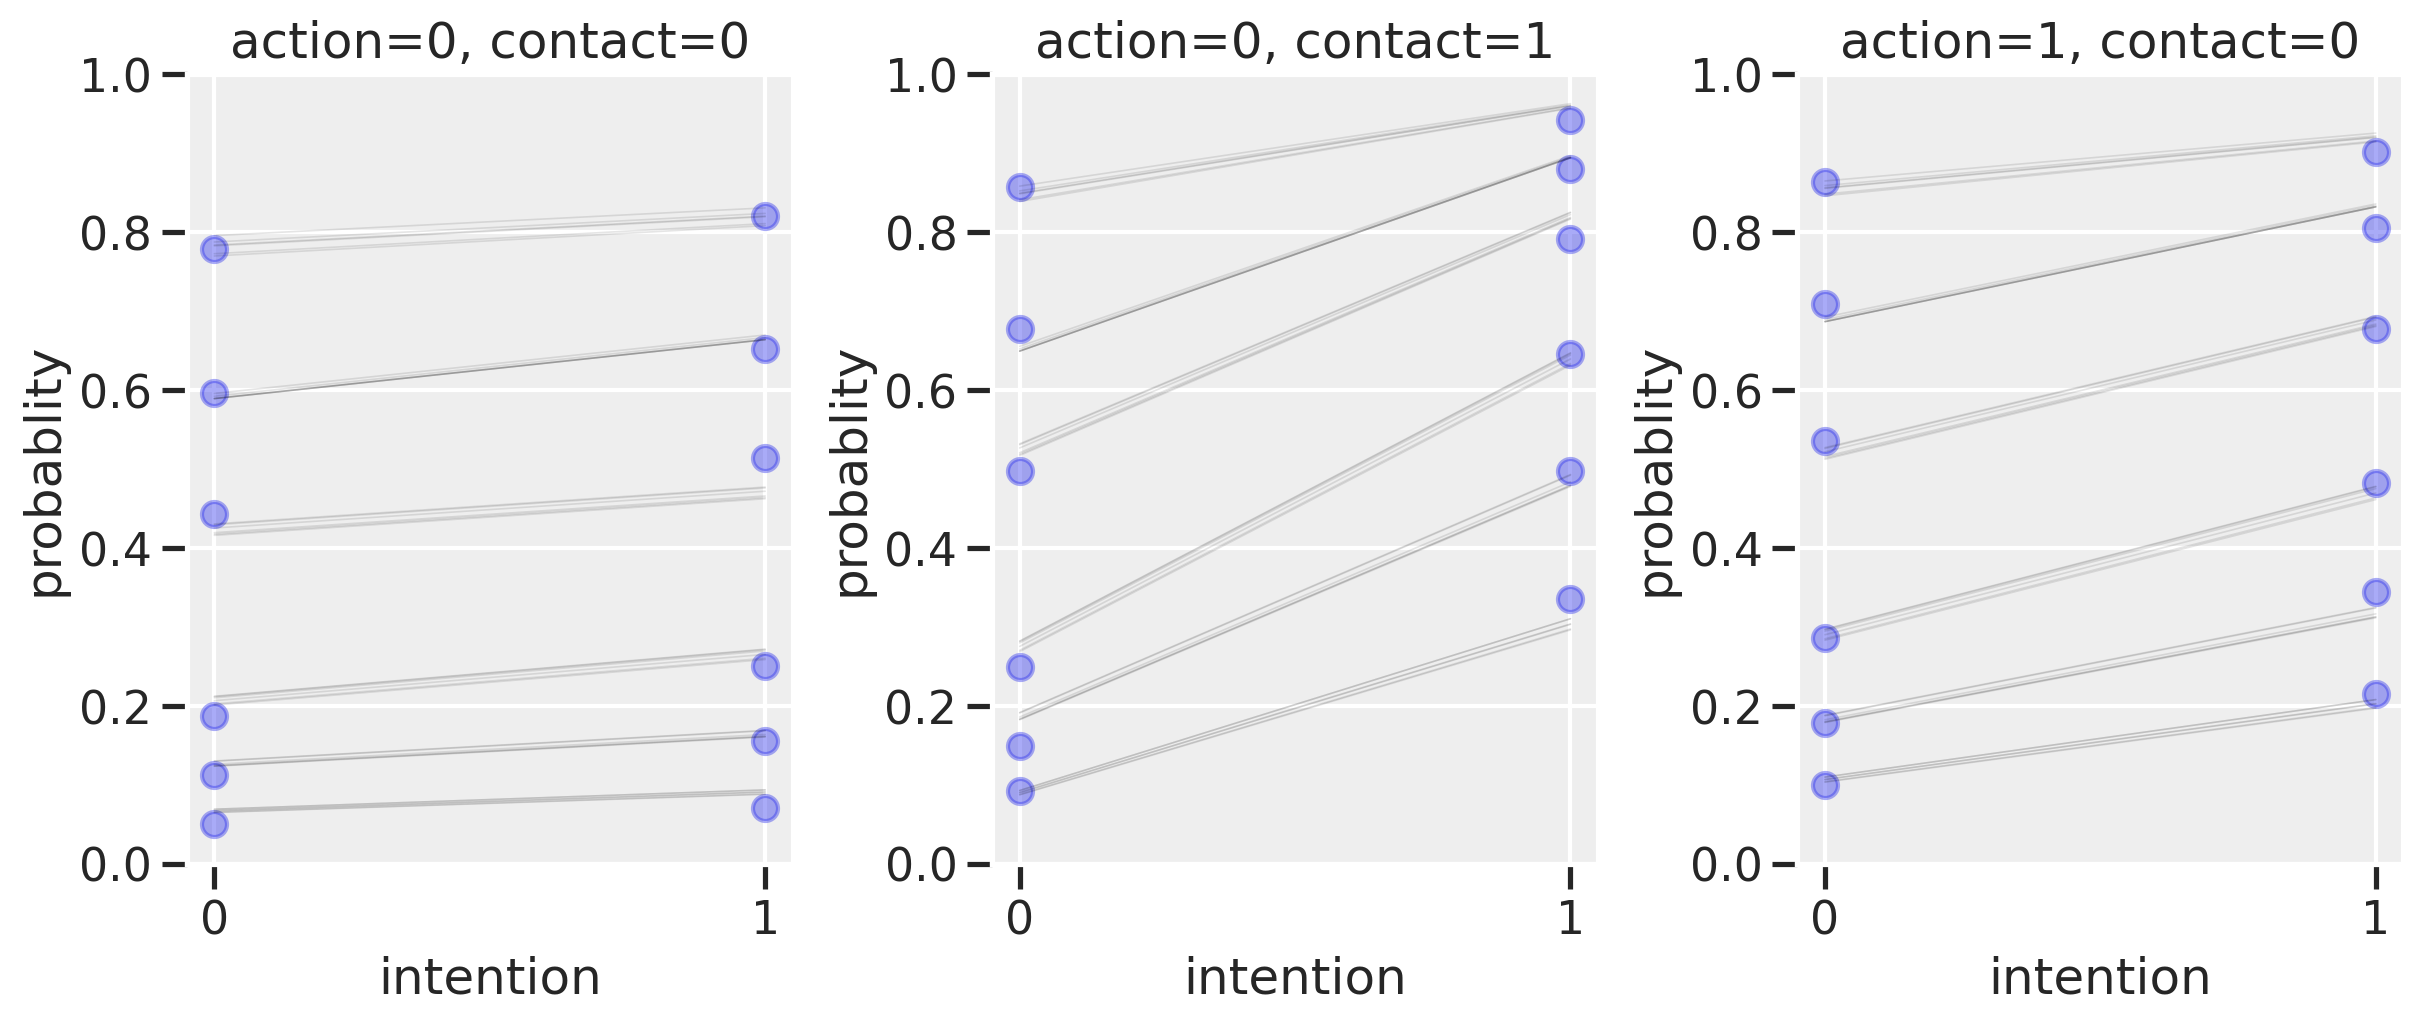

<IPython.core.display.Javascript object>

In [87]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    # p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])
    # altered code  [("posterior", "cutpoints" + str([s]), s)]
    p = p_ord_logit(
        responses=range(6),
        phi=pp_phi[s],
        a=trace_12_5_df[("posterior", "cutpoints" + str([s]), s)],
    )

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].scatter(
                [[0] * 6 + [1] * 6], p_obs.loc[action, contact], alpha=0.4
            )  # alternate to next line
            # axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

## Getting back to the homework problem

# Question 2 (11H8)

Consider one more variable in the Trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes response, education, age, and gender.

Using only the DAG, is it possible that the inferences from Problem 1 are confounded by gender? If so, define any additional models you need to infer the causal influence of education on response. What do you conclude?

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


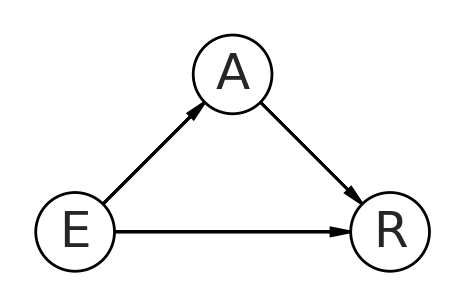

<IPython.core.display.Javascript object>

In [31]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


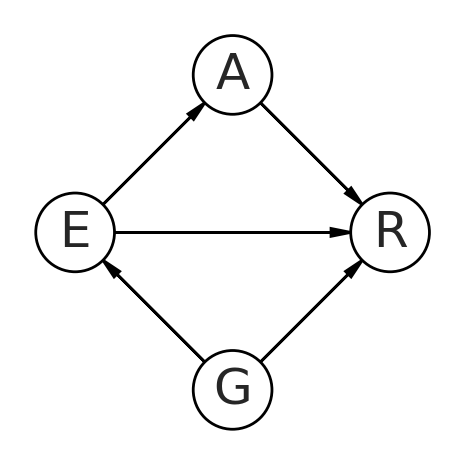

<IPython.core.display.Javascript object>

In [32]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


**Update**

In terms of the paths of G to A, we now have the following:

- G > A (direct)
- G > D > A (D acts as a pipe)
- G > D < US > A (D acts as a collider)

Therefore, we're "hurt" by the fact that we can't answer our question with satisfaction since there are problems whether we condition on D or not.

McElreath's suggestion: "What can be done in these situations? The best thing is to stop analyzing convenient,
confounded data and instead design a real study."

In [37]:
np.array([[1, 2], [3, 4]])**2

array([[ 1,  4],
       [ 9, 16]])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>